# Pandas to PySpark
In this project we will revisit the 'Titanic' project made using Pandas and do it in parallel using PySpark.

This project can act as a comparison of how to achieve certain tasks using Pandas VS using PySpark.

PySpark allows us to process much larger datasets than Pandas.

Notes:
* I am starting the process of learning PySpark.
* This project will contain much less documentation about the Titanic dataset as it is focused on the code.
* The 'variables exploration' section will be much shorter as we skip code repetitions.
* We will sometimes convert PySpark DataFrames to Pandas DataFrame for clarity. We will only do so for small portions of the dataset as to not defeat the point of using PySpark over Pandas. The Machine Learning Section will be done using a Pandas DataFrame and Scikit-learn as I anyway cannot apply models on datasets large enough for PySpark to be necessary.

## Table of Contents
* [Data Exploration](#dataExploration)
* [Data Cleaning](#dataCleaning)
* [Feature Engineering](#featureEngineering)
* [Preprocessing](#preprocessing)
* [Feature Selection](#featureSelection)
* [Hyperparameter Optimization](#hyperparameterOptimization)
* [Model Selection](#modelSelection)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import when, col, count, isnull, regexp_extract

In [3]:
# Matplotlib configuration
mpl.rcParams['figure.figsize'] = 15, 15
mpl.rcParams['figure.dpi'] = 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)        # tells matplotlib to save plots at 300 DPI

# Makes Jupyter show the output of all lines, not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
spark = SparkSession \
    .builder \
    .appName('Titanic') \
    .getOrCreate()

In [5]:
df = pd.read_csv("titanic.csv")
df_spark = spark.read.csv("titanic.csv", inferSchema=True, header=True)

<a id="dataExploration"><a/>

## Data Exploration

In [6]:
df.head()
df_spark.limit(5).toPandas()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [7]:
df.info()
df_spark

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


DataFrame[pclass: int, survived: int, name: string, sex: string, age: double, sibsp: int, parch: int, ticket: string, fare: double, cabin: string, embarked: string, boat: string, body: int, home.dest: string]

In [8]:
df.describe()
df_spark.describe().toPandas()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


,summary,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,count,1309,1309,1309,1309,1046,1309,1309,1309,1308,295,1307,486,121,745
1,mean,2.294881588999236,0.3819709702062643,None,None,29.881137667304014,0.4988540870893812,0.3850267379679144,249039.1368861024,33.29547928134572,None,None,9.404522613065327,160.8099173553719,None
2,stddev,0.8378360189701272,0.48605517086648325,None,None,14.41349321127133,1.0416583905961012,0.8655602753495143,442685.31767656445,51.75866823917421,None,None,4.3574169836049395,97.69692199600308,None
3,min,1,0,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.17,0,0,110152,0.0,A10,C,1,1,"?Havana, Cuba"
4,max,3,1,"van Melkebeke, Mr. Philemon",male,80.0,8,9,WE/P 5735,512.3292,T,S,D,328,"Zurich, Switzerland"


### Variables Exploration


In [9]:
def plot_distribution_by_target(df_pandas, feature, bins=np.linspace(0, 85, 15), target="survived", labels=["died", "survived"], stack=False):
    # plots the distribution of the feature for both values of the boolean target
    # stack: wether to stack distribution or blend them, put True for int features
    if stack:
        plt.hist(
        x=[df_pandas[df_pandas[target] == 0][feature], 
        df_pandas[df_pandas[target] == 1][feature]], 
        stacked=True, 
        color=['r','g'],
        label=labels
    )
    else:
        plt.hist(df_pandas[df_pandas[target] == 0][feature], alpha=.6, label=labels[0], color="r")
        plt.hist(df_pandas[df_pandas[target] == 1][feature], alpha=.6, label=labels[1], color="g")
    title = "{} by {}".format(feature, target)
    plt.title(title)
    plt.legend(loc="upper left")
    plt.xlabel(feature)
    plt.ylabel("Number of passengers")
    plt.show()

#### * survived: (boolean 0 = No; 1 = Yes)

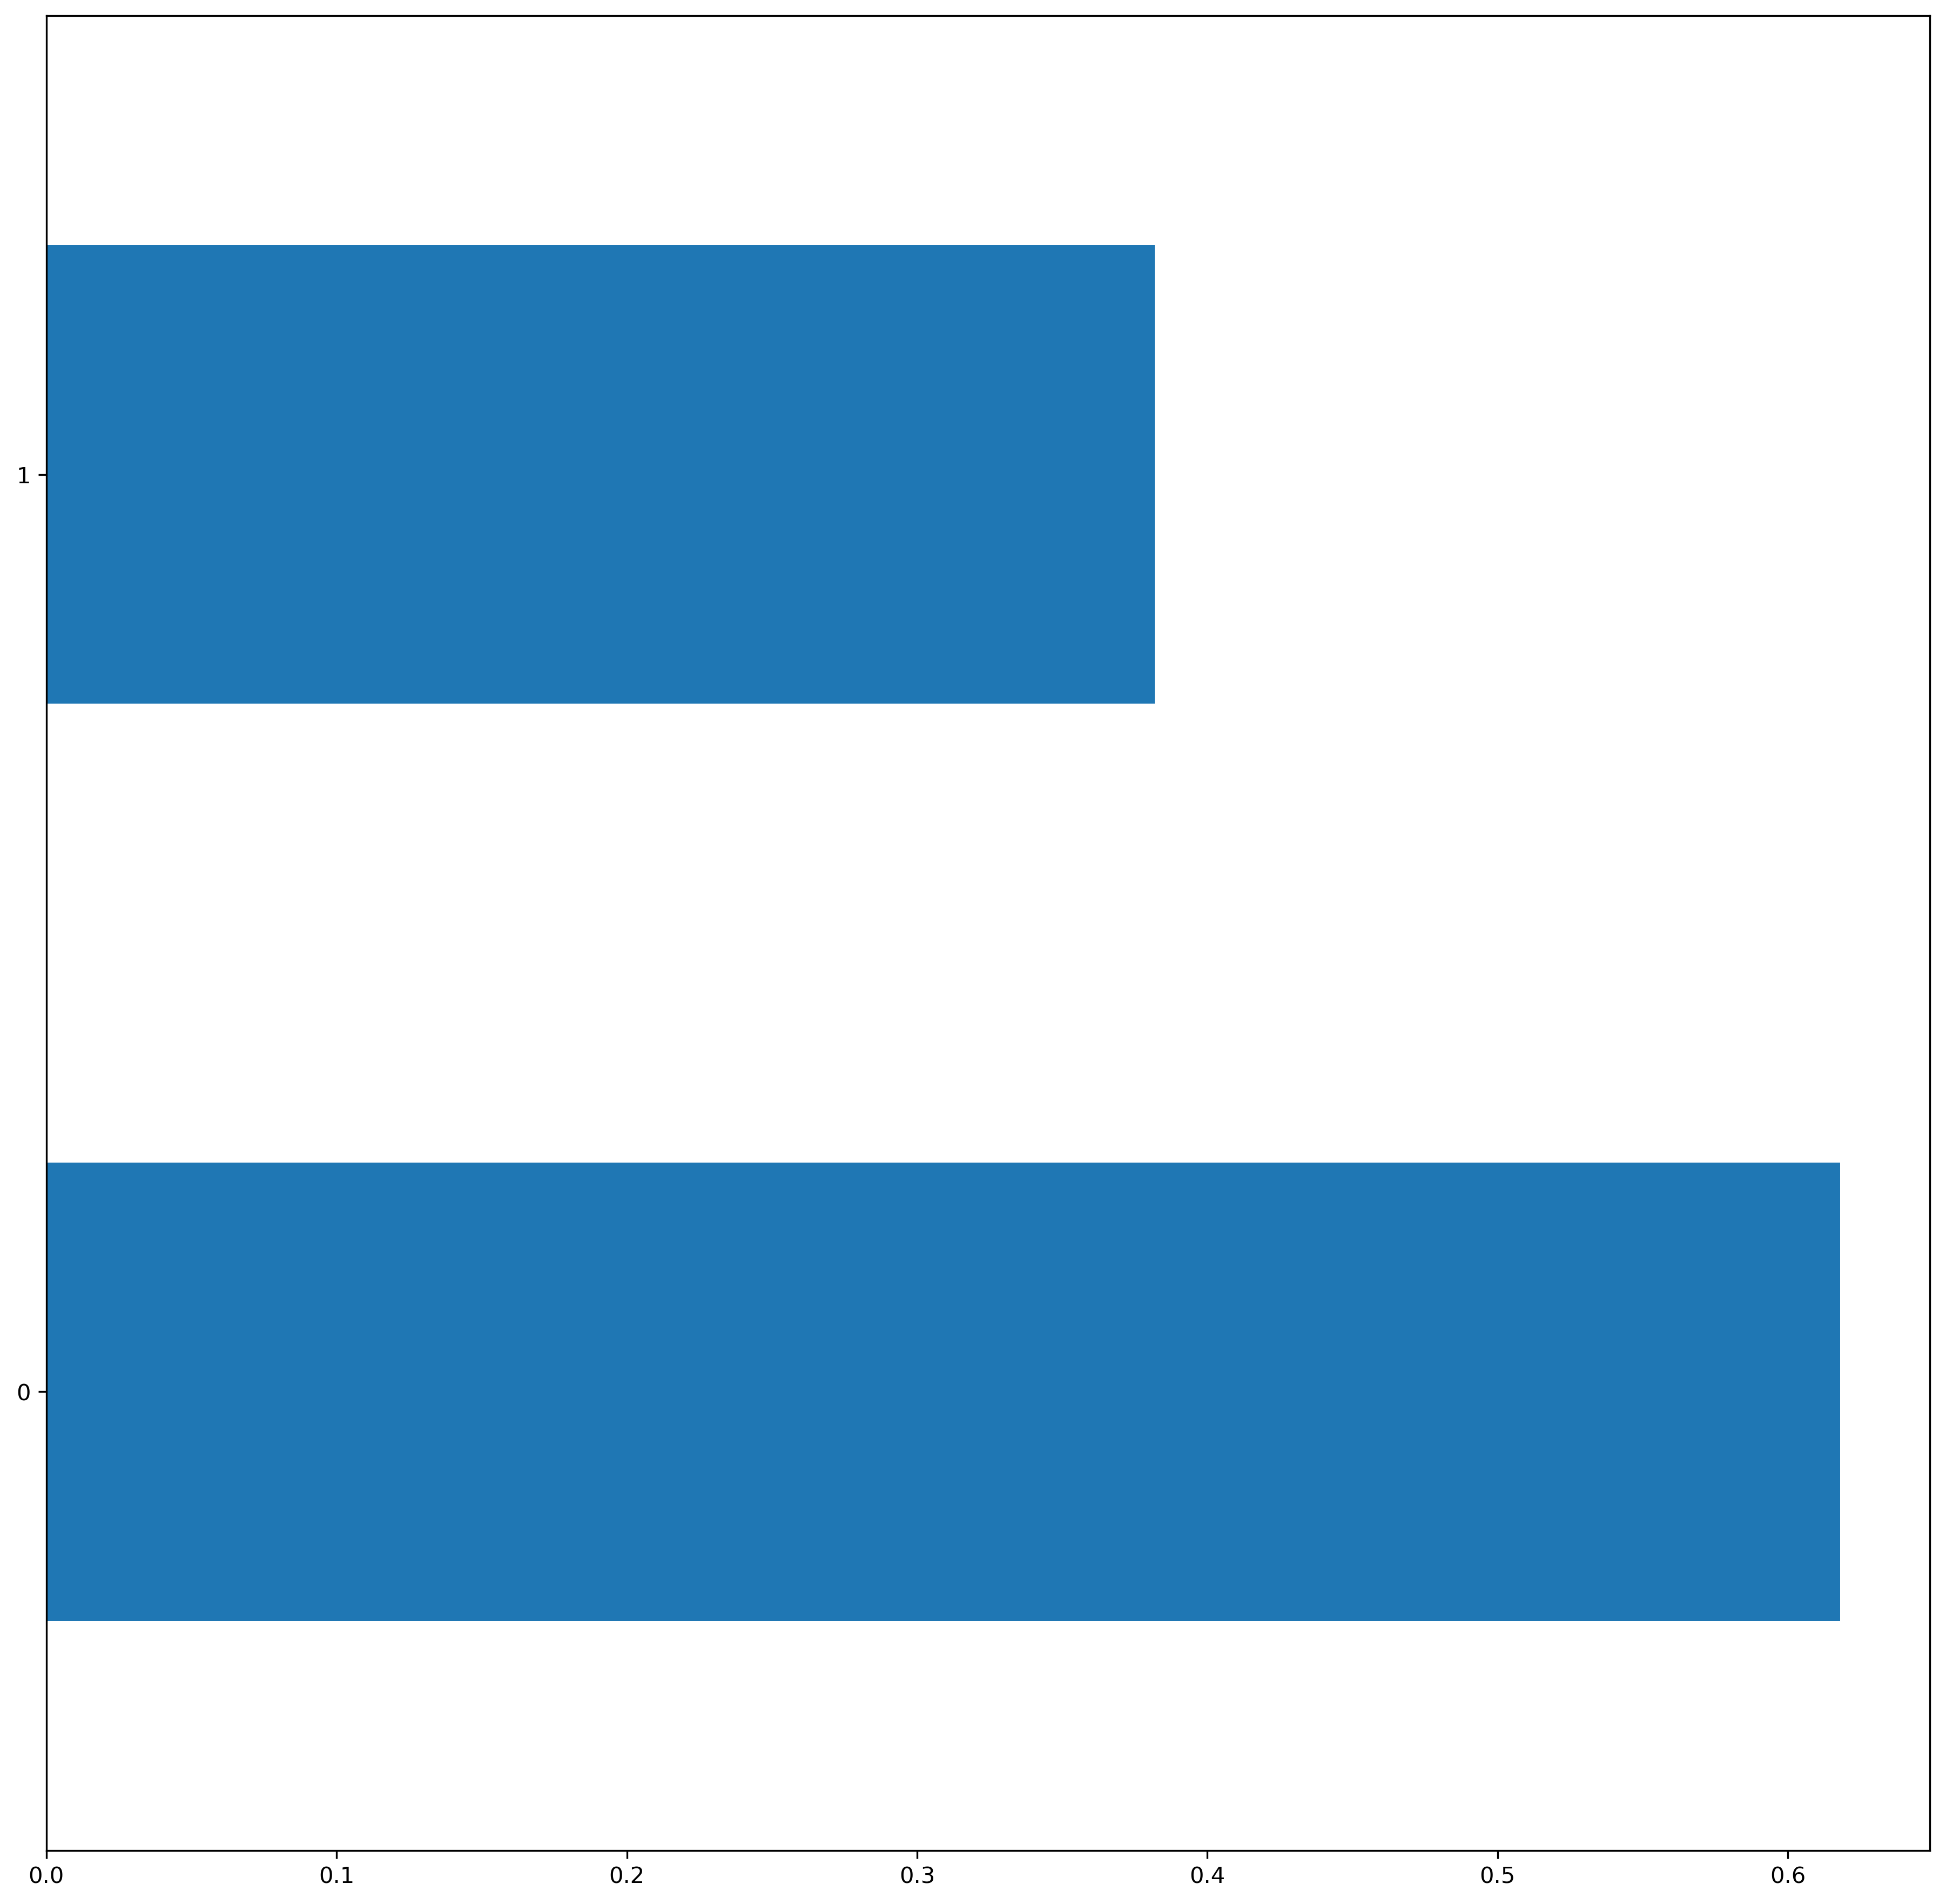

In [10]:
df.survived.value_counts(normalize=True).plot.barh();

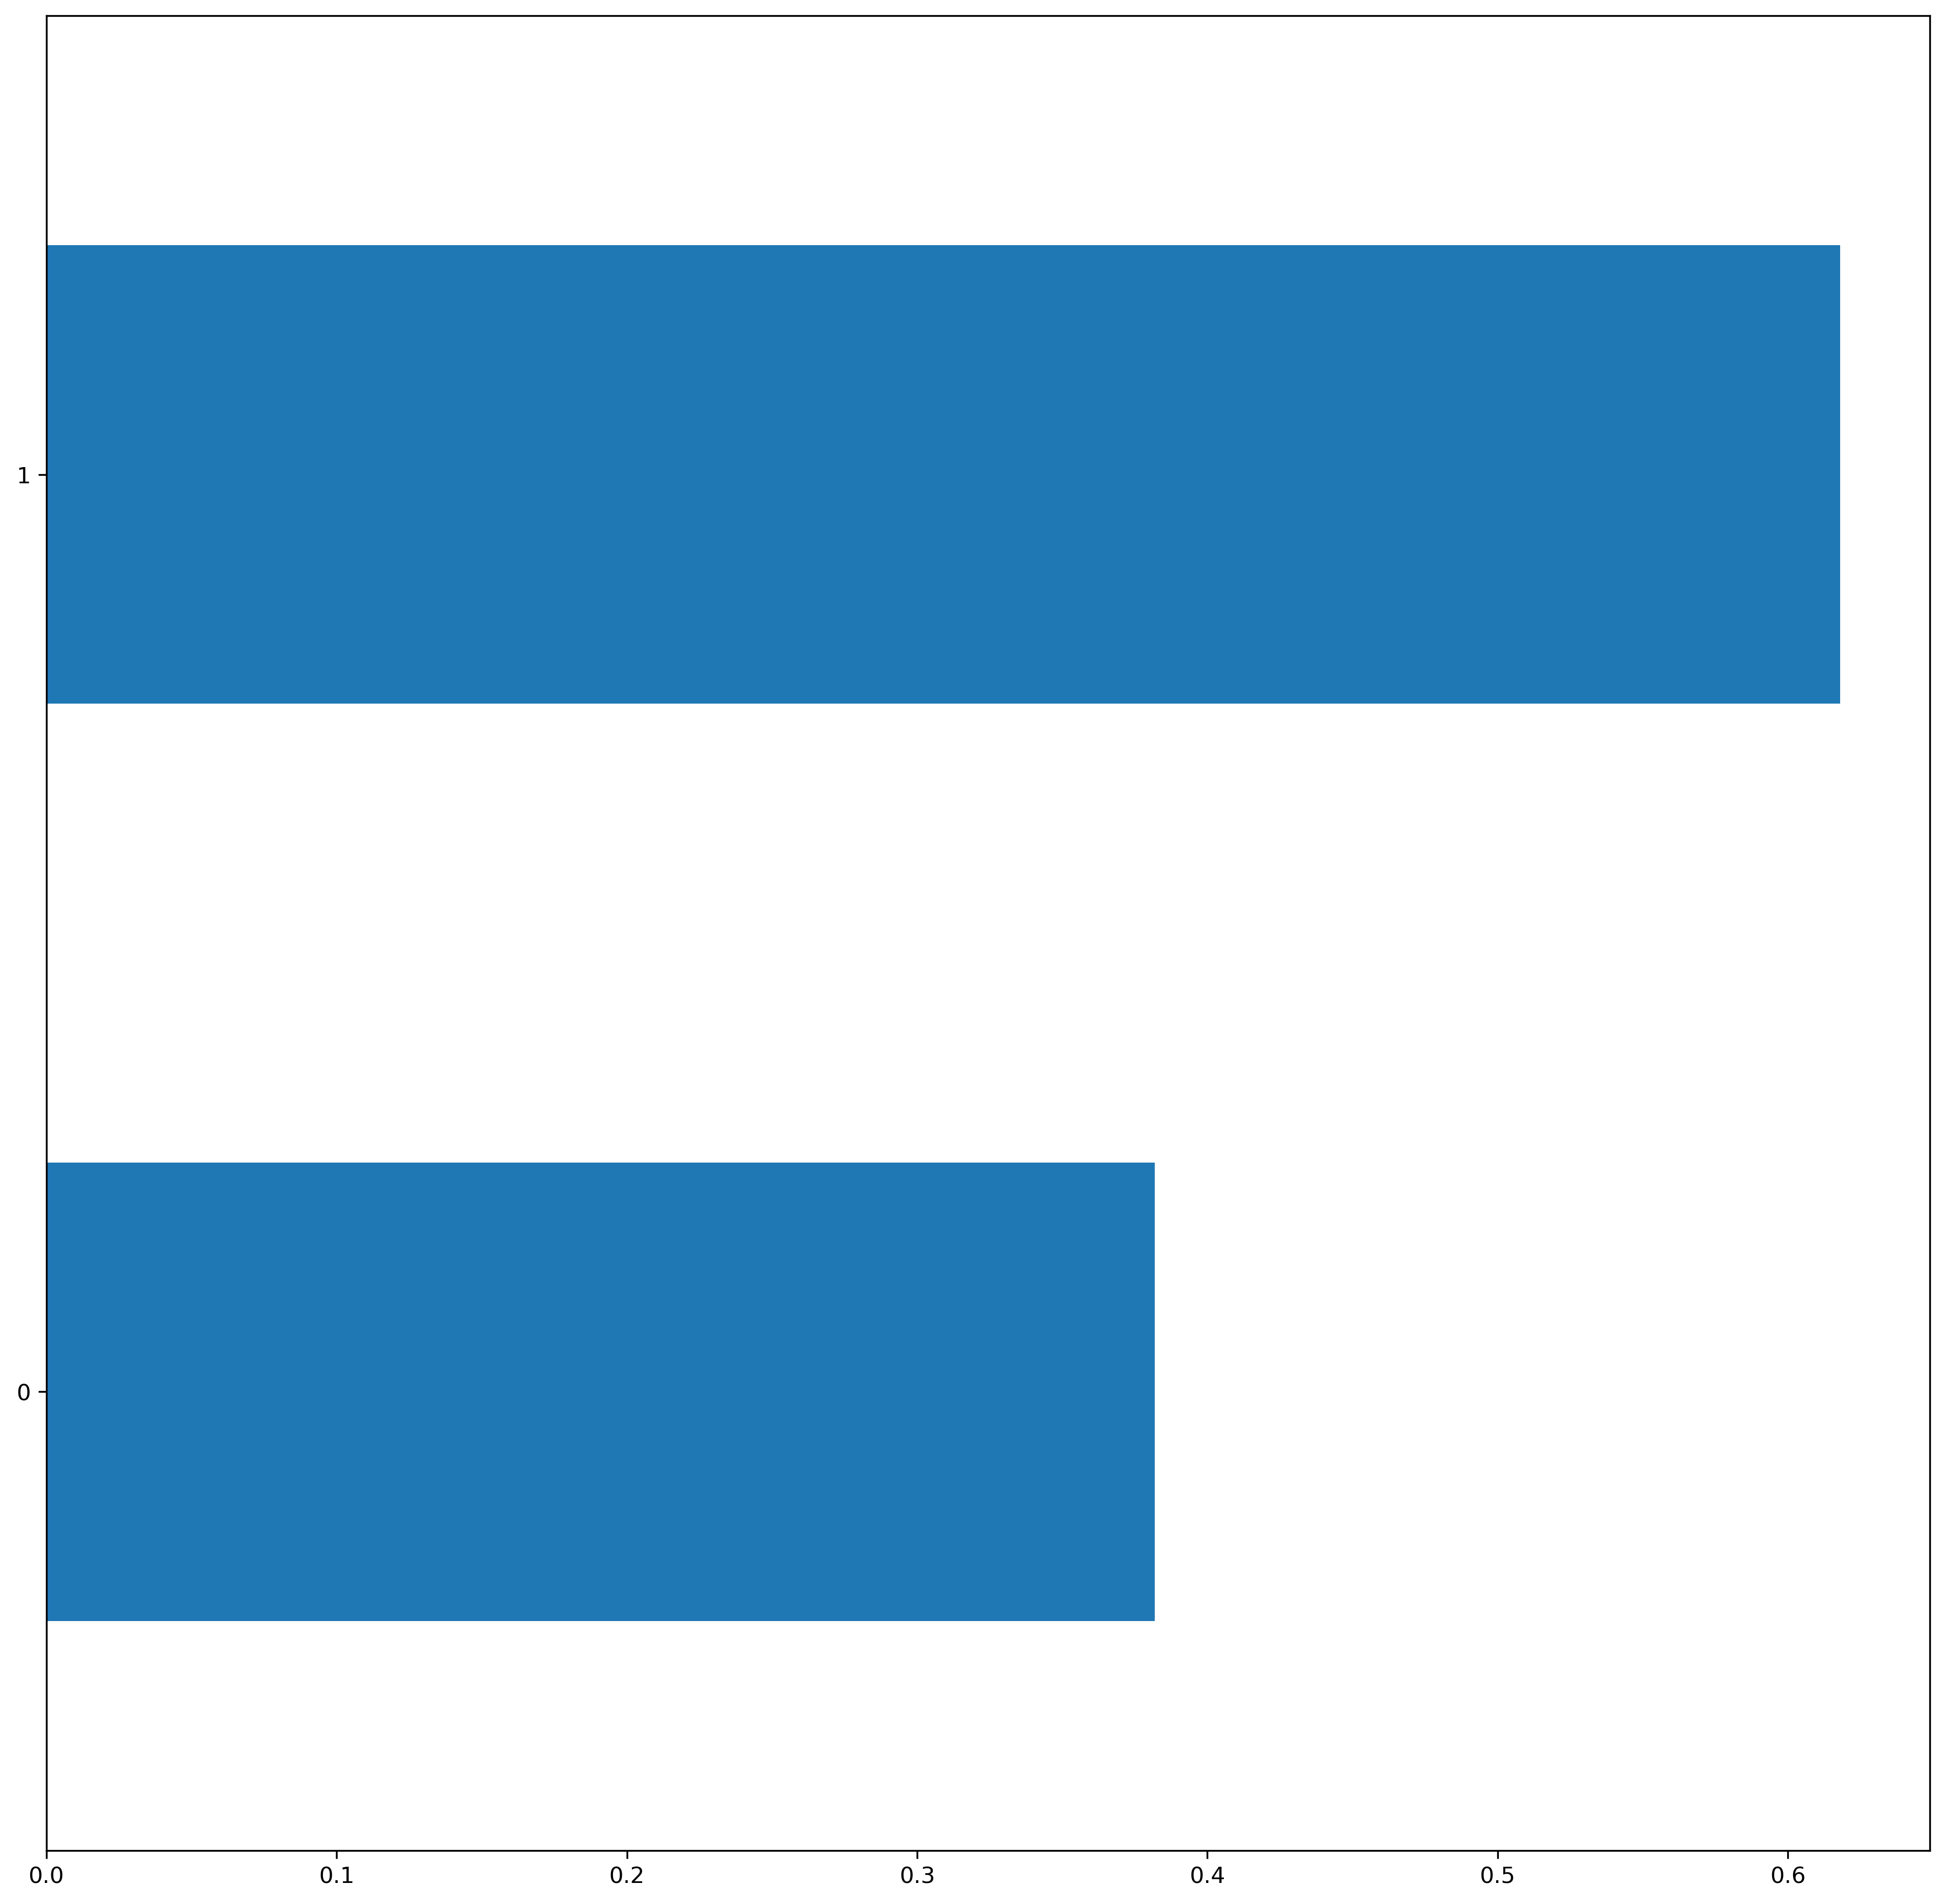

In [11]:
pd.Series(df_spark.groupBy("survived").count().toPandas()["count"] / df_spark.count()).plot.barh();

In [12]:
df_spark.limit(5).toPandas()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [13]:
df.isnull().sum()

# 'home.dest' needs to be ignored or renamed, PySpark does not like '.' in column names
cols = [c for c in df_spark.columns if c != "home.dest"]  
df_spark.select([count(when(isnull(c), c)).alias(c) for c in cols]).toPandas()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body
0,0,0,0,0,263,0,0,0,1,1014,2,823,1188


#### * pclass: Passenger class (ordinal 1 = 1st; 2 = 2nd; 3 = 3rd)

In [14]:
df.pclass.value_counts(normalize=True)

value_counts_spark = df_spark.groupBy('pclass').count().orderBy('count').toPandas()
value_counts_spark["count"] = value_counts_spark["count"] / df_spark.count()  # normalizes
value_counts_spark

3    0.541635
1    0.246753
2    0.211612
Name: pclass, dtype: float64

,pclass,count
0,2,0.211612
1,1,0.246753
2,3,0.541635


The 3rd class clearly dominates with a presence of more that 54%.
Classes 1 and 2 are roughly evenly spread among the remaining passengers.

C:\Users\BASTIONMaxime\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


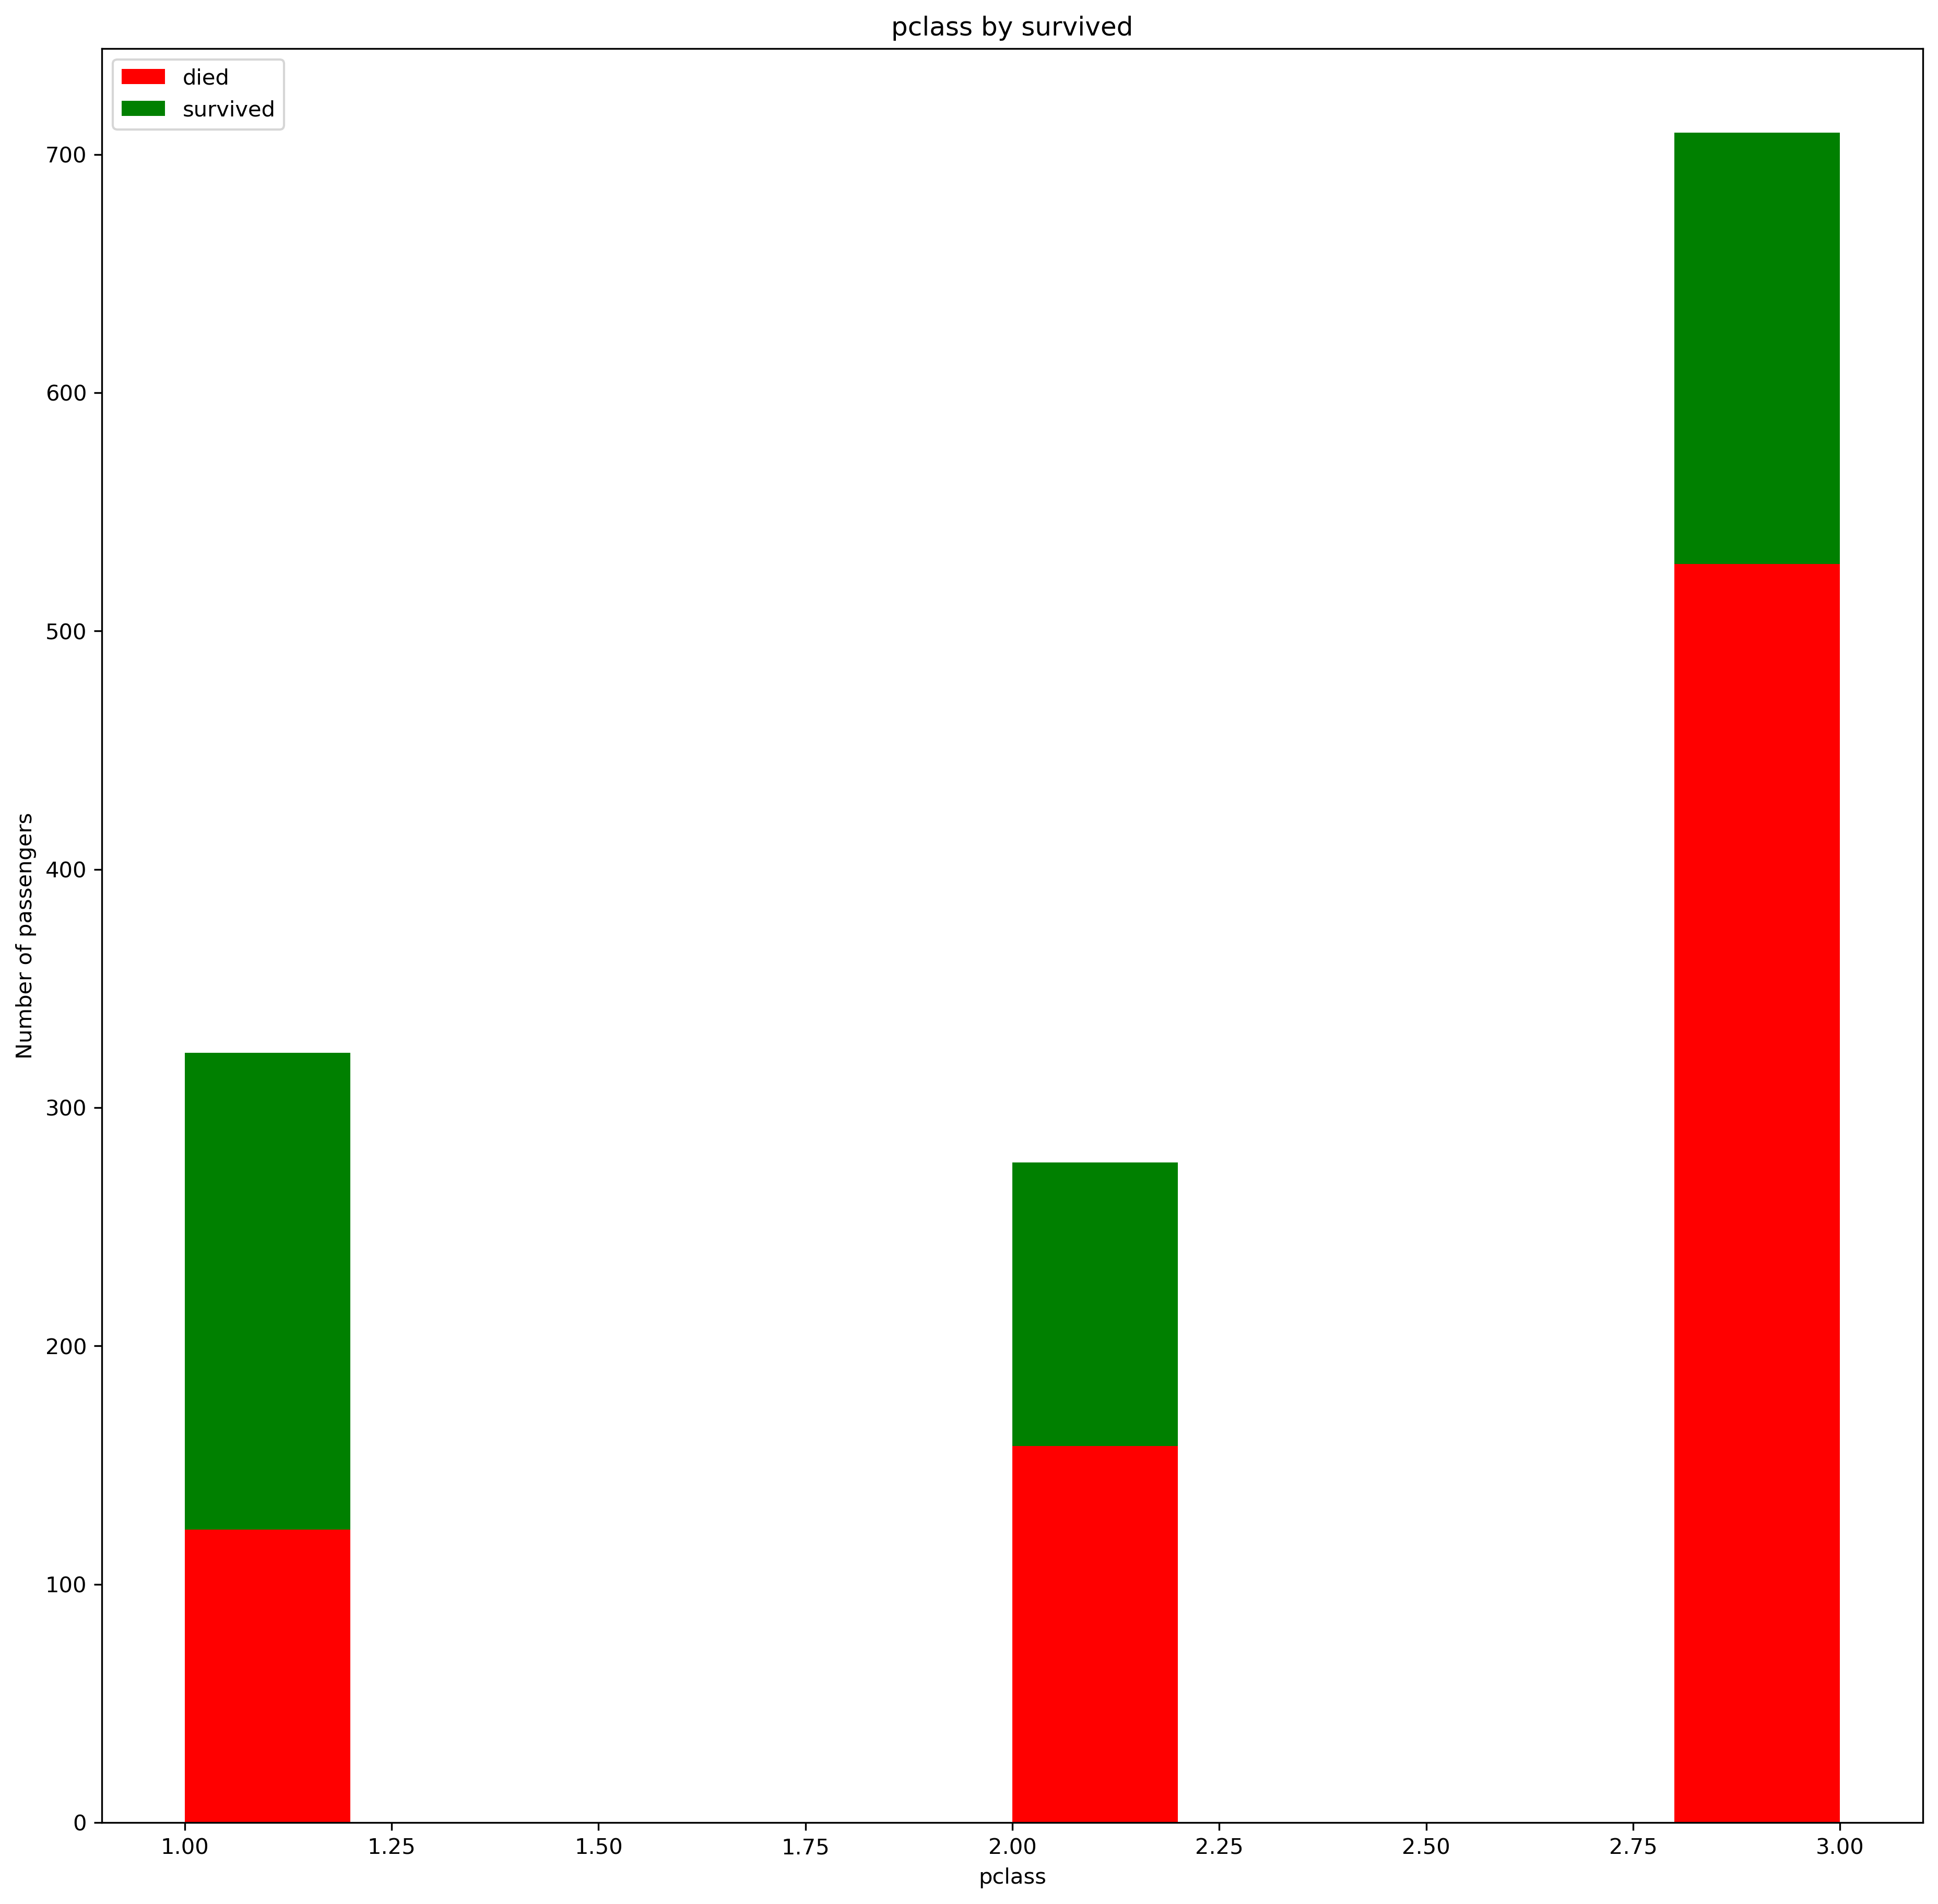

In [15]:
plot_distribution_by_target(df, feature="pclass", stack=True)

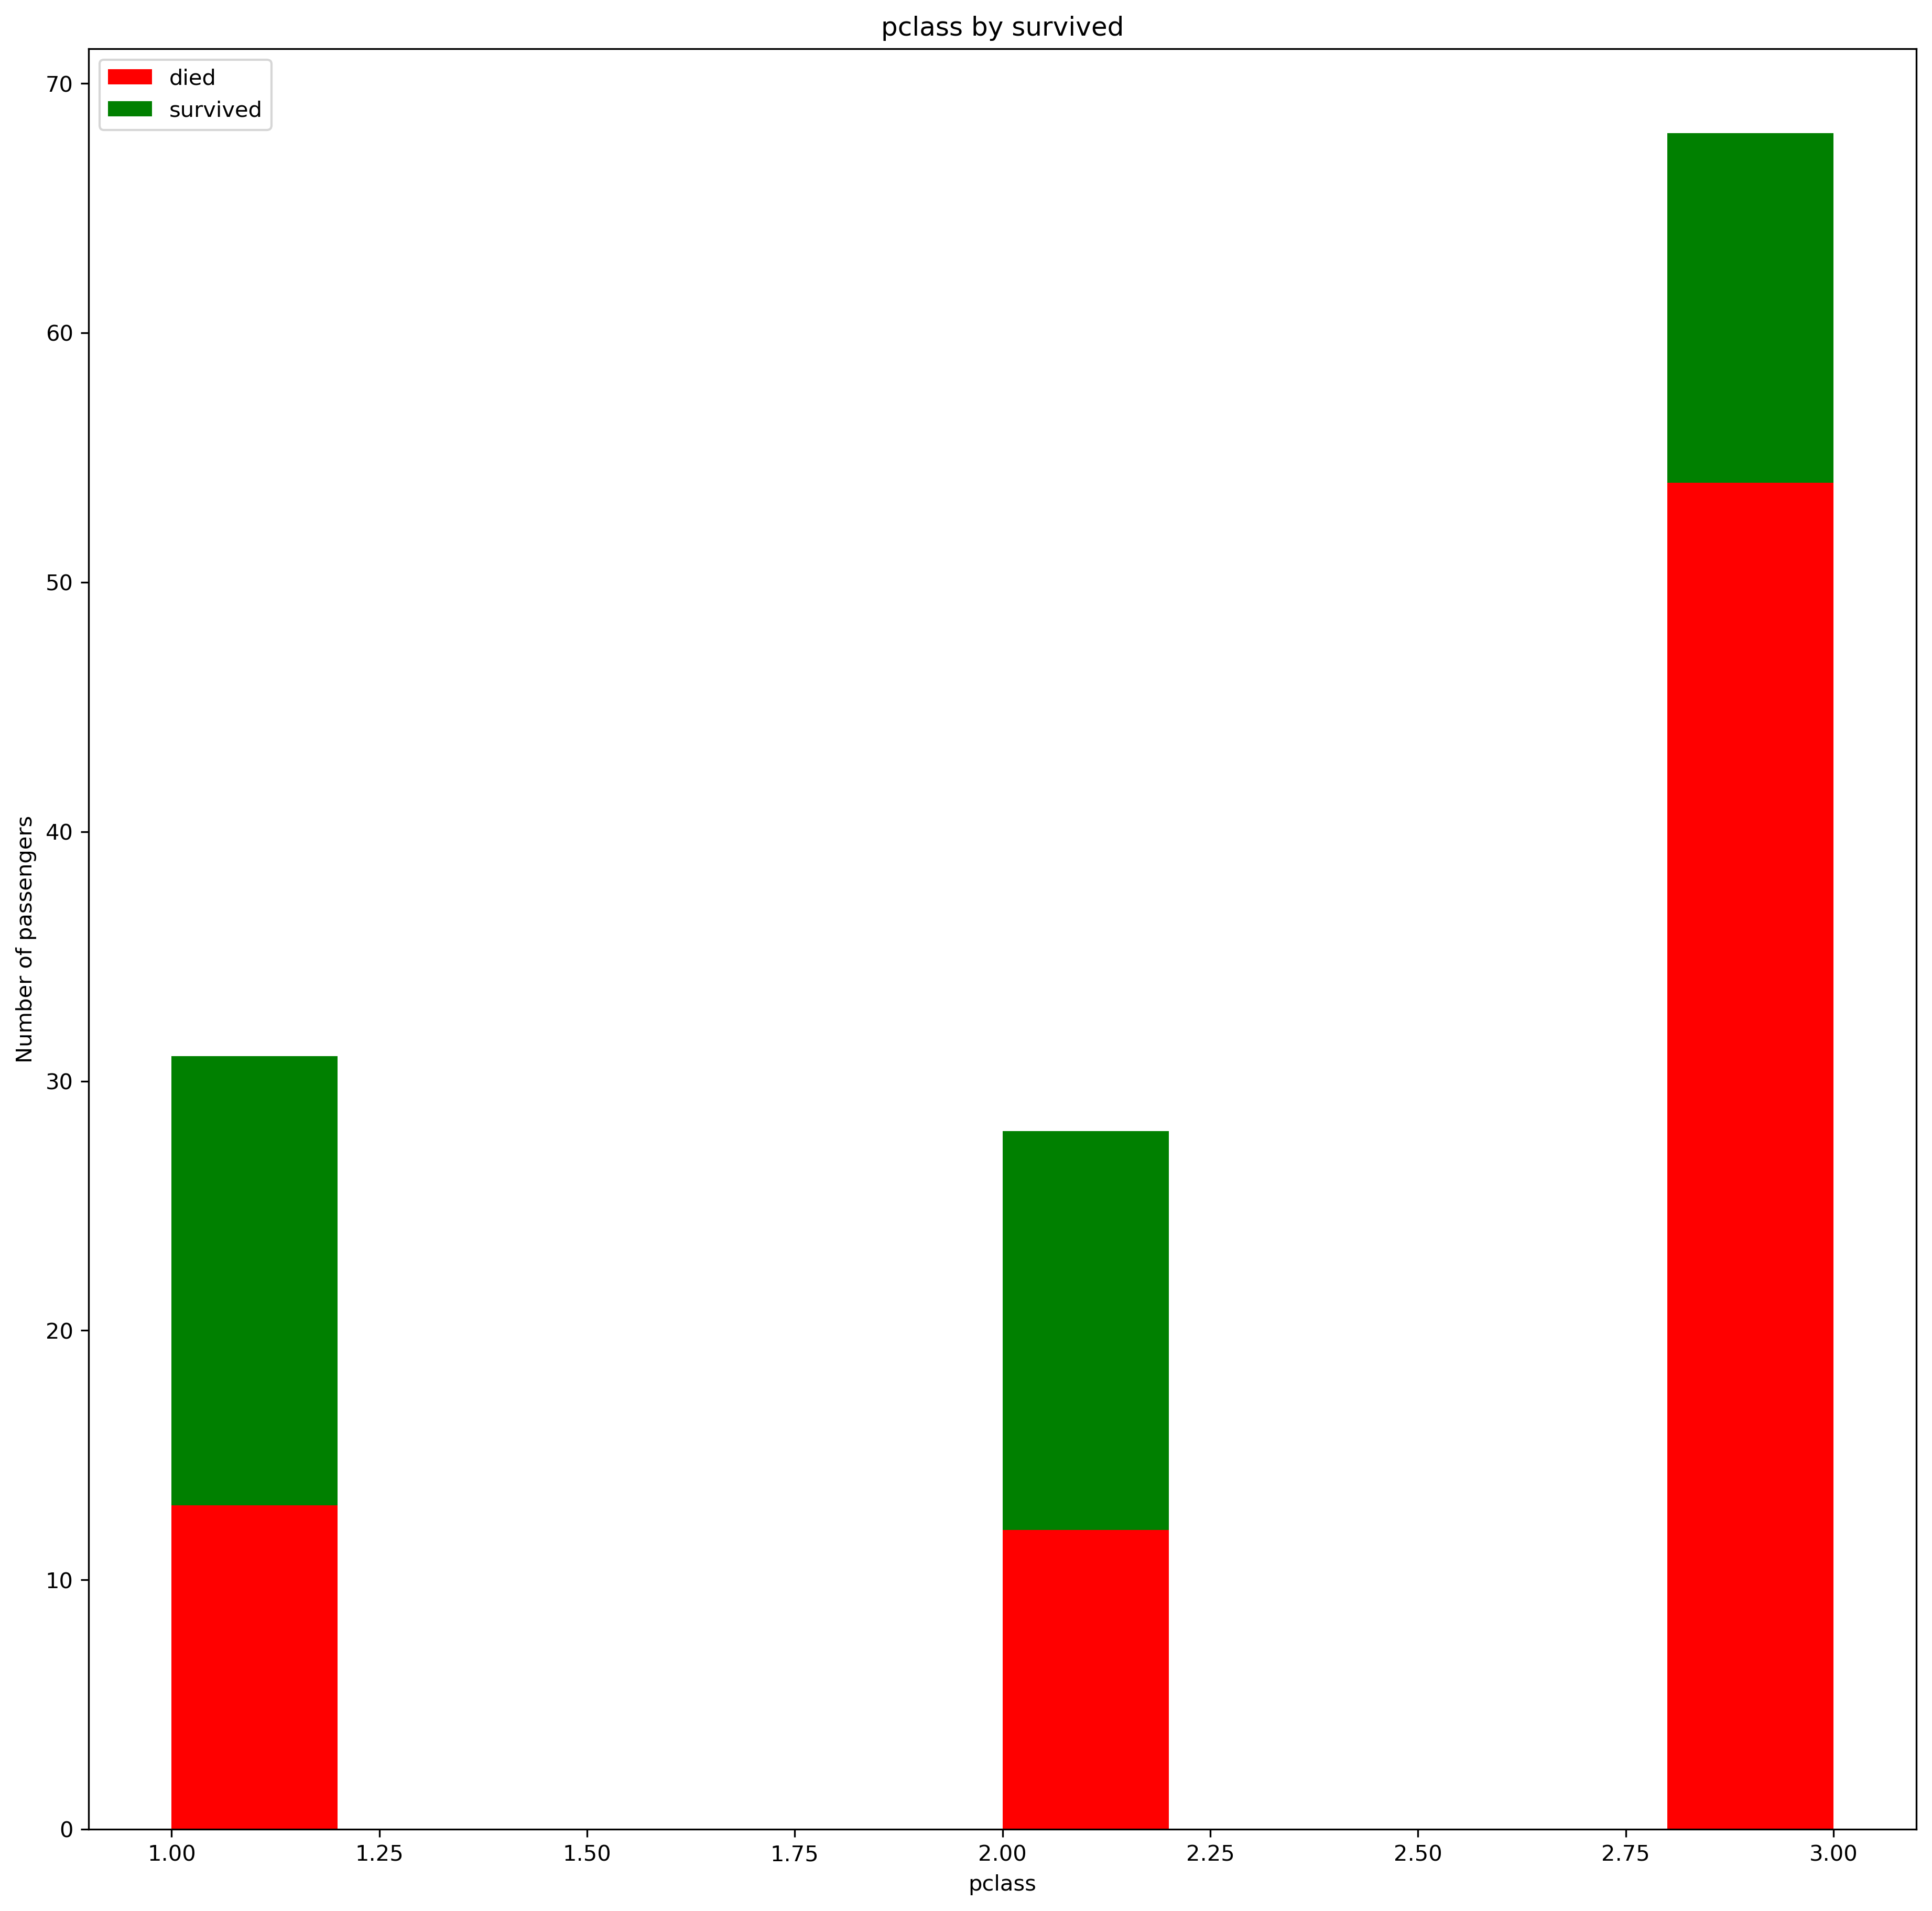

In [16]:
plot_distribution_by_target(df_spark.sample(False, .1).toPandas(), feature="pclass", stack=True)

In [17]:
df.groupby("pclass").mean()["survived"]
df_spark.groupby("pclass").mean().select(["pclass", "avg(survived)"]).toPandas()

pclass
1    0.619195
2    0.429603
3    0.255289
Name: survived, dtype: float64

,pclass,avg(survived)
0,1,0.619195
1,3,0.255289
2,2,0.429603


The better the class, the better the probability of survival.

There is a 36% survival rate difference between the best and the worst class!

#### * name

This feature could be used to create new features.
We could imagine extracting titles from the name to capture new information about a passenger.

In [18]:
list(df.name.head())
list(df_spark.limit(5).toPandas().name)

['Allen, Miss. Elisabeth Walton',
 'Allison, Master. Hudson Trevor',
 'Allison, Miss. Helen Loraine',
 'Allison, Mr. Hudson Joshua Creighton',
 'Allison, Mrs. Hudson J C (Bessie Waldo Daniels)']

['Allen, Miss. Elisabeth Walton',
 'Allison, Master. Hudson Trevor',
 'Allison, Miss. Helen Loraine',
 'Allison, Mr. Hudson Joshua Creighton',
 'Allison, Mrs. Hudson J C (Bessie Waldo Daniels)']

#### *sex 

In [19]:
df.sex.describe()
df_spark.select("sex").describe().toPandas()

count     1309
unique       2
top       male
freq       843
Name: sex, dtype: object

,summary,sex
0,count,1309
1,mean,None
2,stddev,None
3,min,female
4,max,male


#### * age

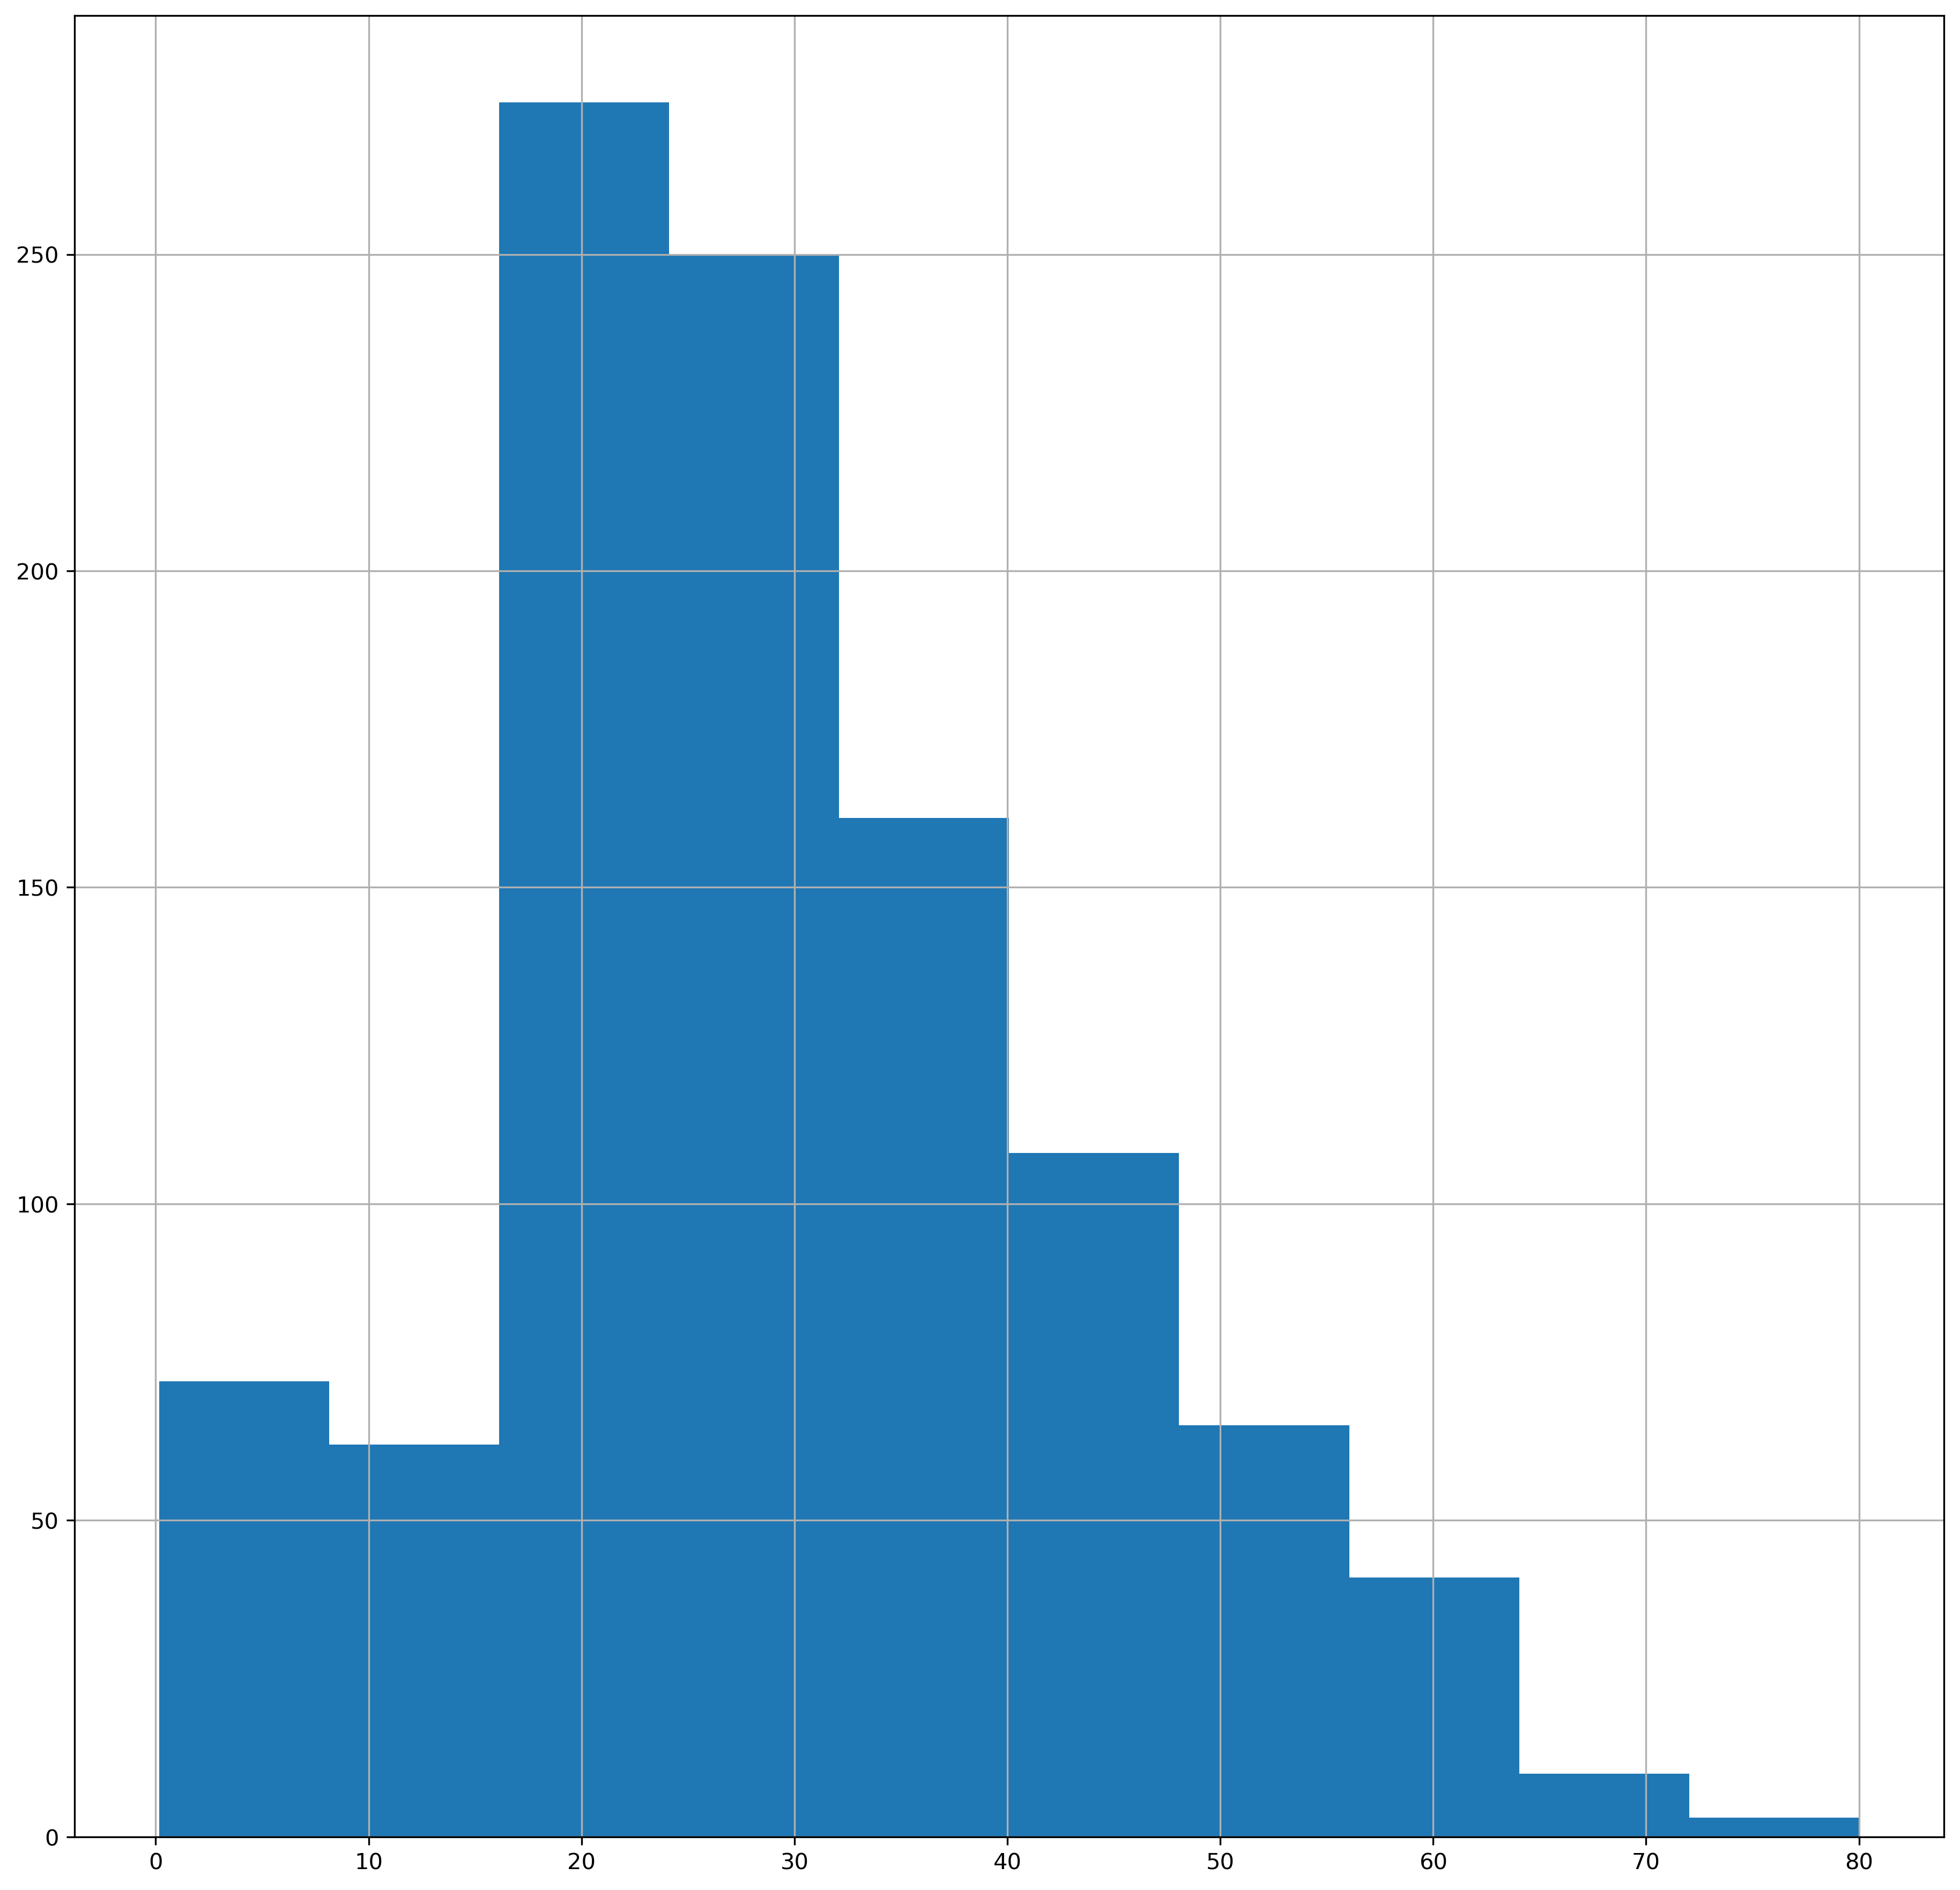

In [20]:
df.age.hist();

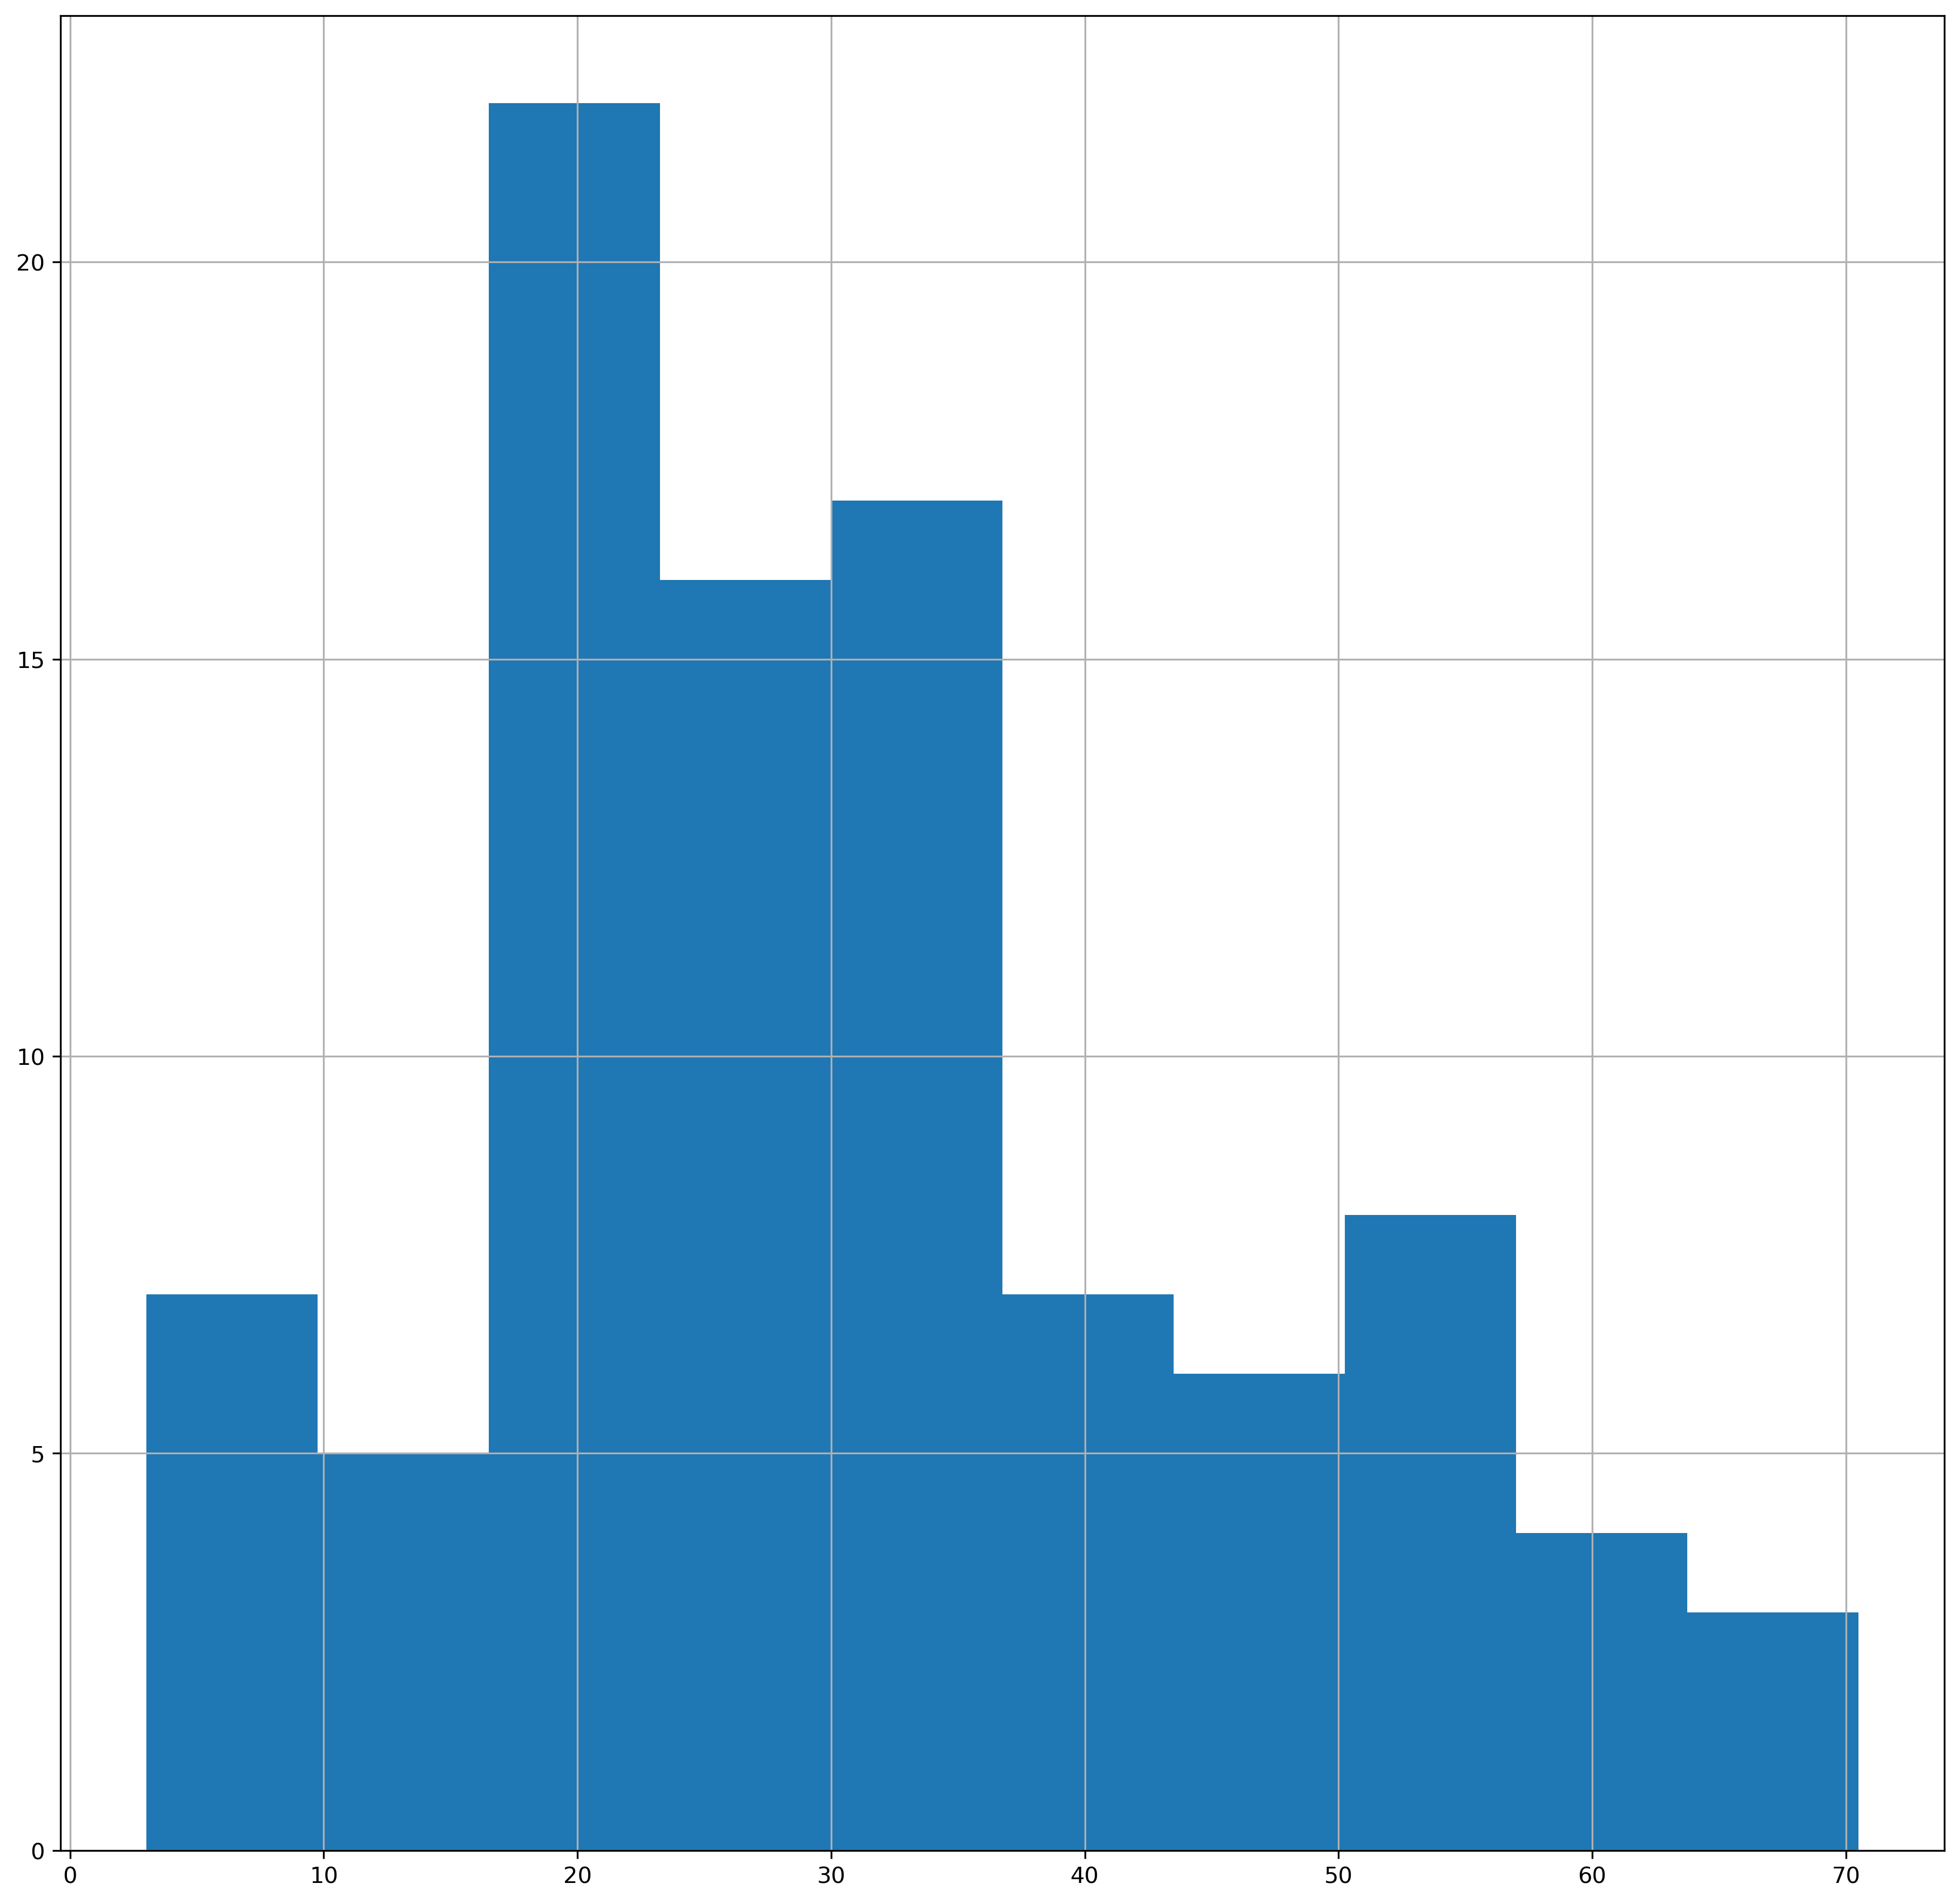

In [21]:
df_spark.sample(False, .1).toPandas().age.hist();

The most common ages refer to infants or young adults.

In [22]:
infants = df[df.age <= 2]
infants_spark = df_spark[df_spark.age <= 2]

#### * embarked (Port of Embarkation C = Cherbourg; Q = Queenstown; S = Southampton)

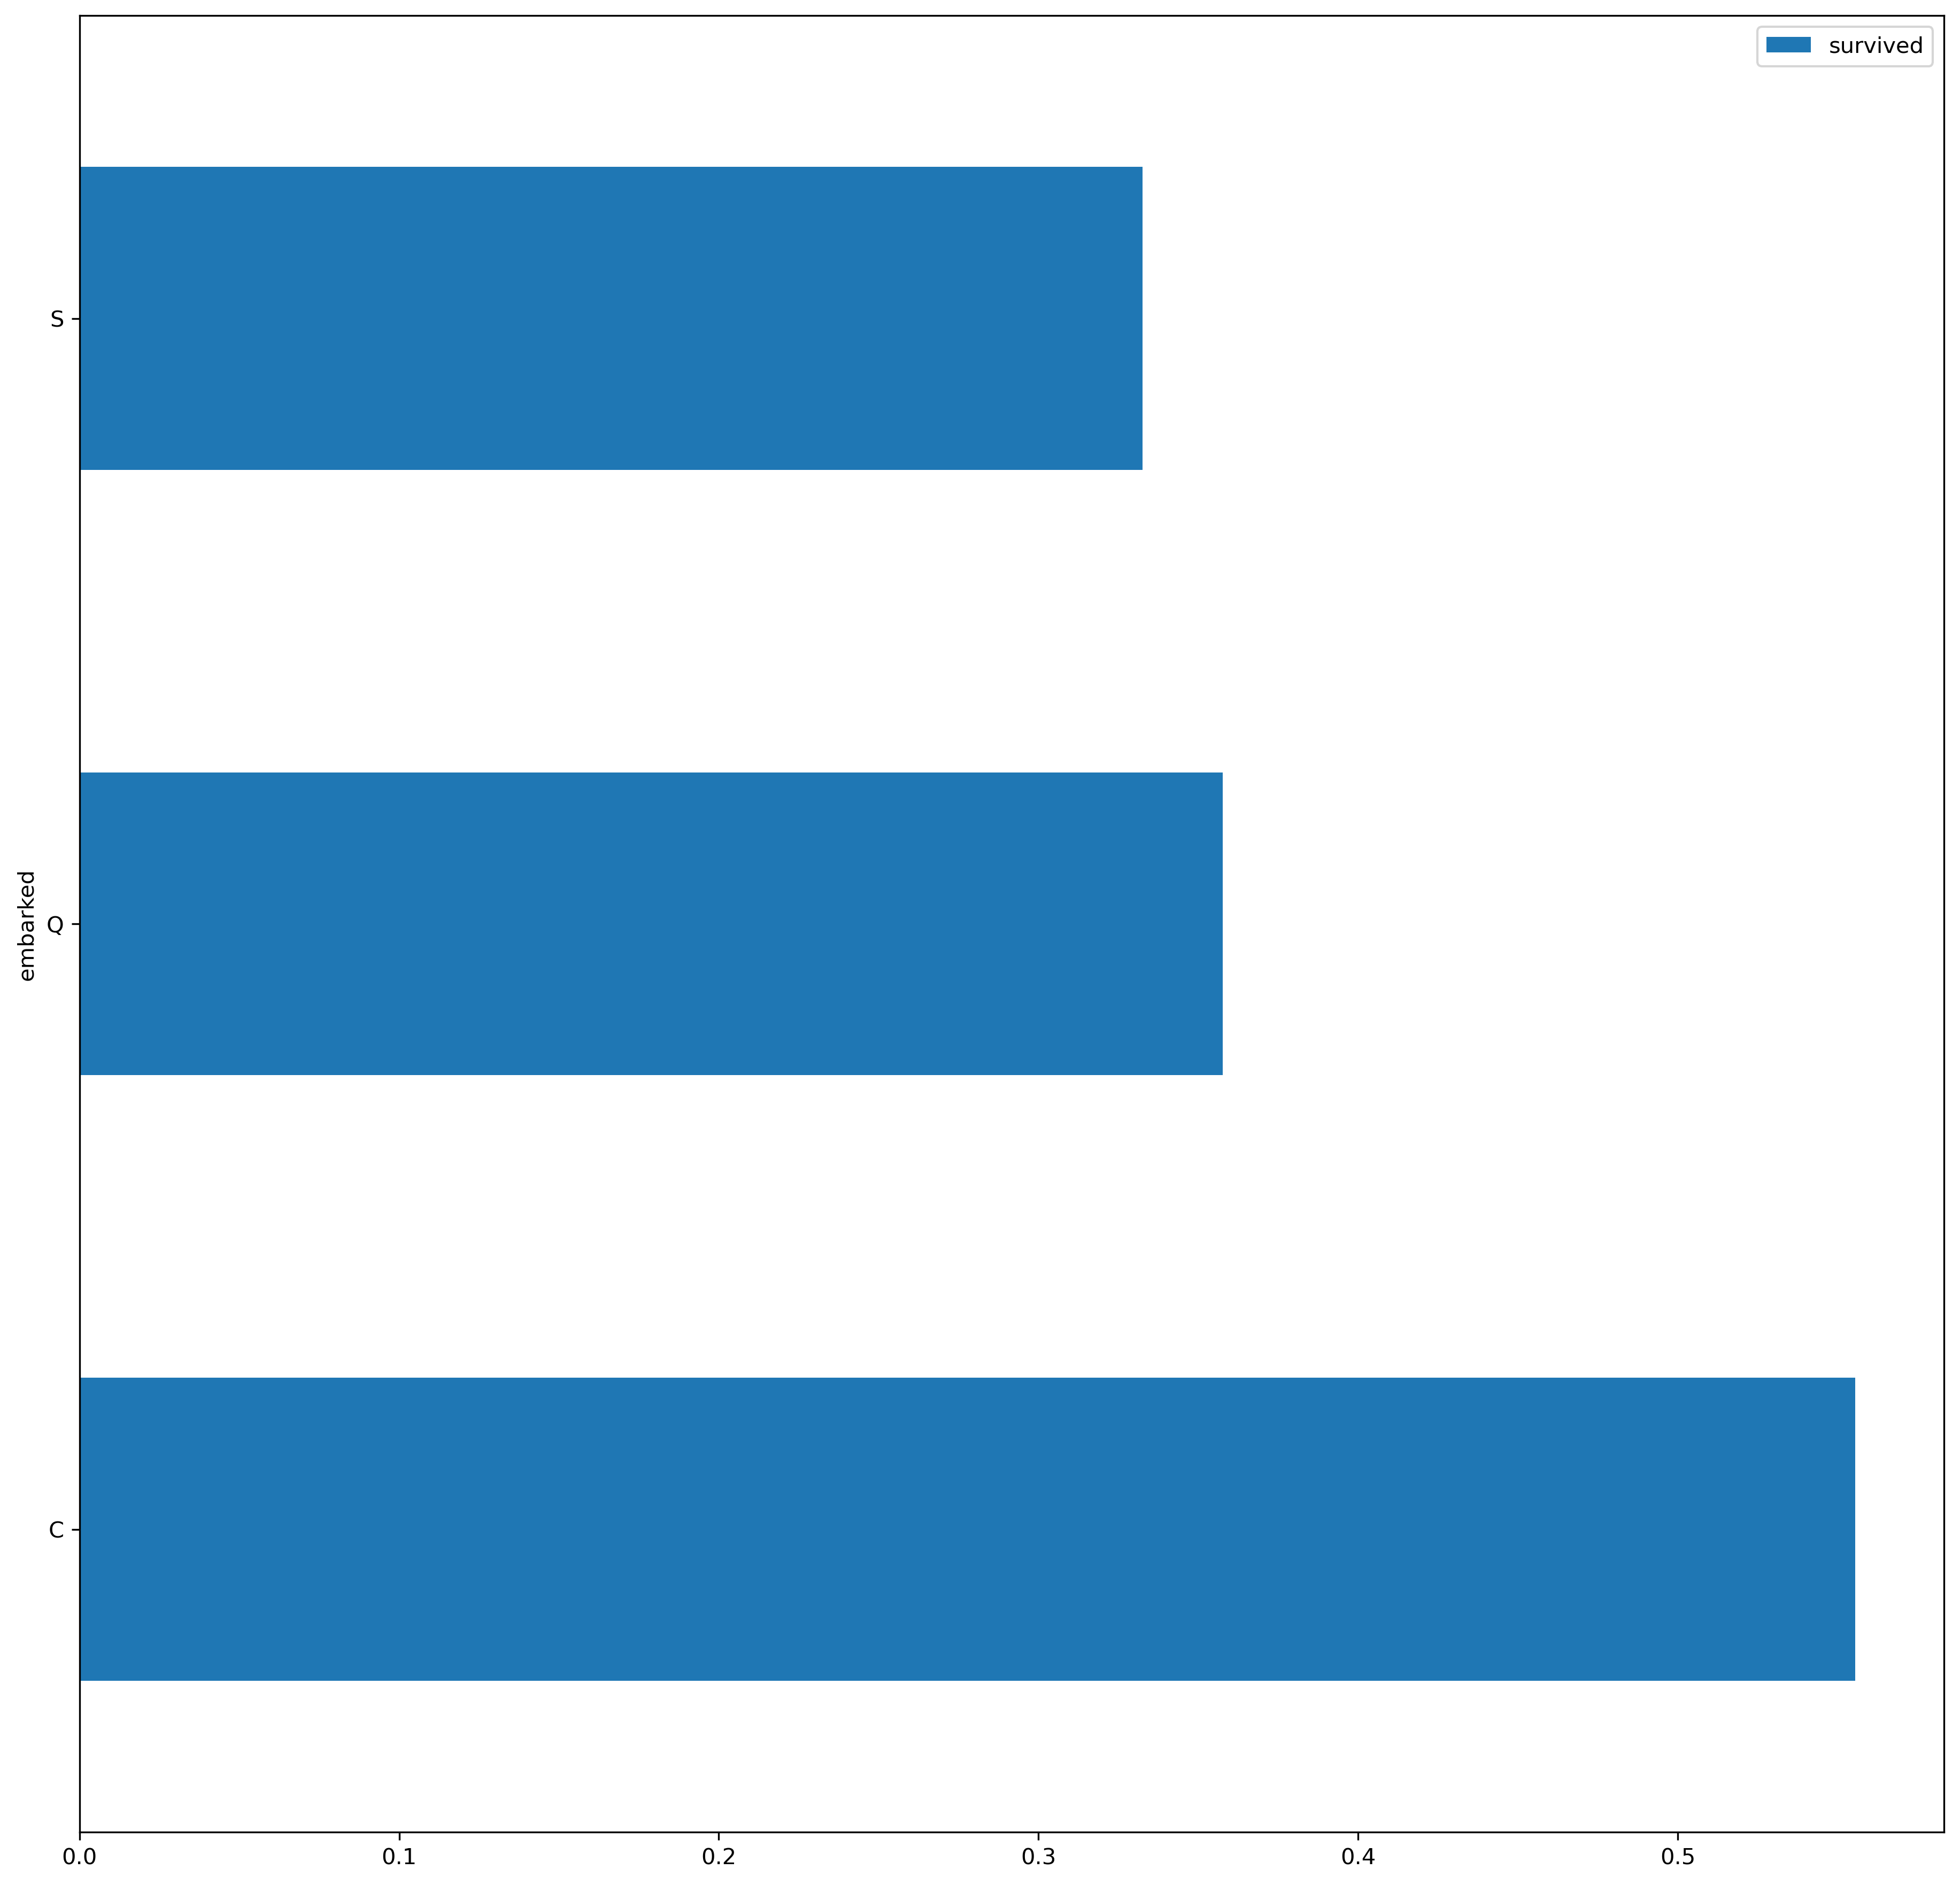

In [23]:
df[["embarked", "survived"]].groupby("embarked").mean().plot.barh();

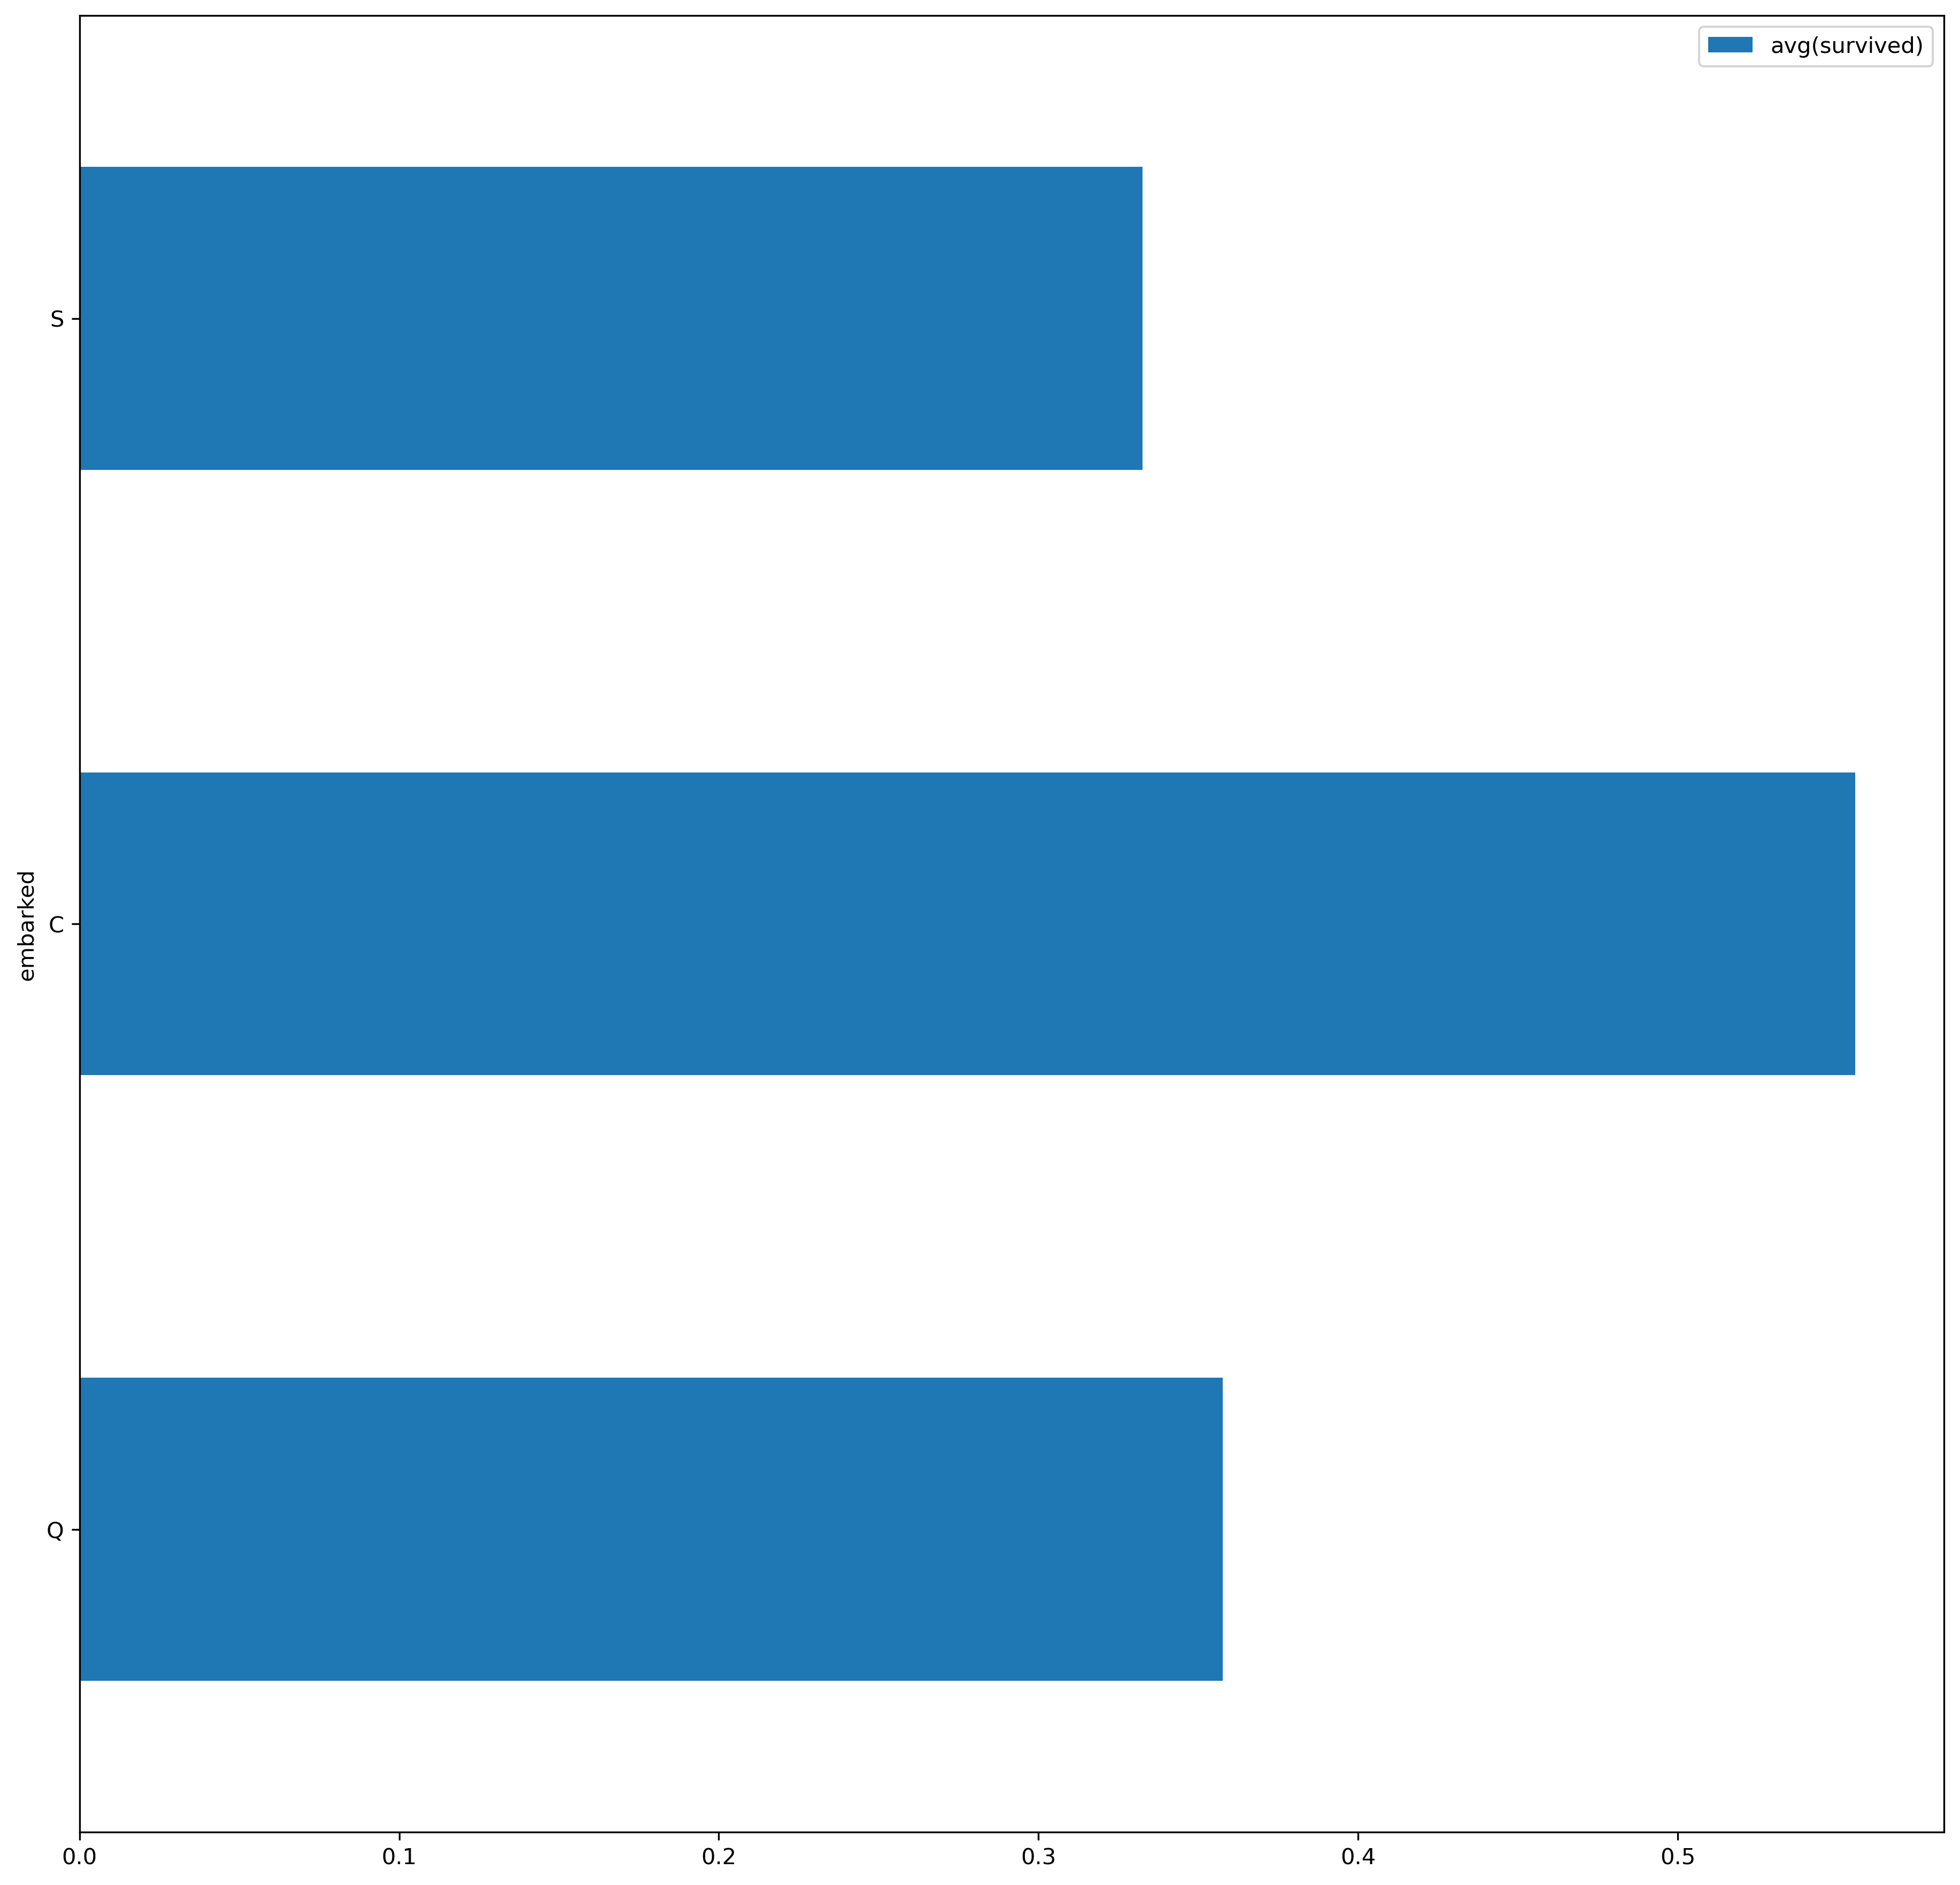

In [24]:
df_spark.select(["embarked", "survived"]).na.drop().groupby("embarked").mean().toPandas().plot.barh(x="embarked")

### What we learned
After completing the data exploration, we note that:
* We should drop home.dest and cabin
* We should drop name but explore creating features with it
* sibsp and parch have a similar pattern: not being alone is good for your survival. We could group these variables into a new feature 'is_alone'

<a id="dataCleaning"><a/>

## Data Cleaning

In [25]:
df = df.drop(columns=["boat", "body", "ticket", "home.dest", "cabin"])
df_spark = df_spark.drop("boat", "body", "ticket", "home.dest", "cabin")

<a id="featureEngineering"><a/>

### Feature Engineering
We can create new features from existing ones.

* #### is_alone

In [26]:
df["is_alone"] = df.apply(lambda row: 1 if row["sibsp"] + row["parch"] == 0 else 0, axis=1)
df_spark = df_spark.withColumn("is_alone",
                               when((df_spark.sibsp == 0) & (df_spark.parch == 0), 1)
                               .otherwise(0))

In [27]:
cols_to_corr = ["survived", "is_alone"]
df[cols_to_corr].corr()

,survived,is_alone
survived,1.000000,-0.201719
is_alone,-0.201719,1.000000


In [28]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

def get_corr_df_from_spark(df_spark, cols_to_corr):
    """
    Returns a pearson correlation pandas DataFrame from a PySpark DataFrame
    cols_to_corr: list of name of colums to correlate, only accepts numeric cols containing no nulls
    """

    # Converts the columns to corr to a vector
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=cols_to_corr, outputCol=vector_col)
    df_vector = assembler.transform(df_spark).select(vector_col)

    matrix = Correlation.corr(df_vector, vector_col)
    
    # Converts the matrix (1d numpy array) to a pandas DataFrame
    corr_array = matrix.collect()[0]["pearson({})".format(vector_col)].values
    corr_df = pd.DataFrame(corr_array.reshape(-1, len(cols_to_corr)), columns=cols_to_corr, index=cols_to_corr)
    return corr_df

In [29]:
get_corr_df_from_spark(df_spark, cols_to_corr)

,survived,is_alone
survived,1.000000,-0.201719
is_alone,-0.201719,1.000000


There is a weak correlation between not being alone and surviving.

We will try this feature.

In [30]:
df = df.drop(columns=["sibsp", "parch"])
df_spark = df_spark.drop("sibsp", "parch")

* #### title

In [31]:
df["title"] = df.name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_spark = df_spark.withColumn(
    "title",
    regexp_extract(col("name"), ' ([A-Za-z]+)\.', 1)
)

We will only consider the 4 most common titles. The rest will be grouped as 'other'.

In [32]:
df["title"] = df.title.apply(
    lambda title: title if title in ["Mr", "Miss", "Mrs", "Master"] else "other"
)
df_spark = df_spark.withColumn(
    "title",
    when(col("title").isin(["Mr", "Miss", "Mrs", "Master"]), col("title"))
    .otherwise("other")
)

In [33]:
df = df.drop(columns=["name"])
df_spark = df_spark.drop("name")

<a id="preprocessing"><a/>

## Preprocessing
Before we can use our features in our prediction models, we need to format them.

In [34]:
target = "survived"

X = df.drop([target], axis=1)
X_spark = df_spark.drop("target")

### Handling Missing Values
Missing values can prevent us from using certain models. We need to drop or impute them.

In [35]:
df.isnull().sum().sort_values(ascending=False)
df_spark.select([count(when(isnull(c), c)).alias(c) for c in df_spark.columns]).toPandas()

age         263
embarked      2
fare          1
title         0
is_alone      0
sex           0
survived      0
pclass        0
dtype: int64

,pclass,survived,sex,age,fare,embarked,is_alone,title
0,0,0,0,263,1,2,0,0


We are missing too many values for 'age' do drop the passengers with missing age. The other missing values do not matter much.

We will handle the missing age and fare values by imputing them using a K-Nearest-Neighbors Imputer. It will look at the n most similar passengers and take the mean of their ages.
We will handle the missing embarked values by imputing with the most common value.

### ColumnTransformer
We will apply all of our processing tasks using two ColumnTransformer. They allow us to chain operations together

With the first ColumnTransformer, we will convert 'age' and 'fare' from numeric columns to categorical columns, as the relationship between them and 'survival' is not linear, it makes more sense to think of ages and fares as groups, such as 'young' or 'paid a low price'. To do that we will:
* Impute using KNNImputer
* Bin (grouping into ranges) using KBinsDiscretizer
* OneHotEncode to make 'age' and 'fare' categories

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer


numeric_features = ["age", "fare"]
categorical_features = ["sex", "embarked", "title", "pclass", "is_alone"]

numeric_transformer = Pipeline(
    steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('binner', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')),
    ('encoder', OneHotEncoder())]
)
ct = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features)
    ]
)
X_num = ct.fit_transform(X)
X_num = X_num.toarray()
X_num

array([[0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

The output of the ColumnTransformer is a 2D array. To have a better visibility over our preprocessed data, we need to format it into a DataFrame with the right feature names. To do this, we get back the feature names the OneHotEncoder chose, and convert them back to [variable_name]_[category_name] as they are otherwise in the xi_[category_name] format otherwise, which is hard to read.

In [37]:
def replace_xy_by_feature_name(feature, original_categorical_feature_names):
    # converts a feature name from x0_female to sex_female
    pre, post = feature.split("_")
    feature_index = int(pre[1:])
    new_pre = original_categorical_feature_names[feature_index]

    if "." in post:  # in case the feature name contains a float, which occurs for fare and age
        post = post.split(".")[0]
        
    new_name = new_pre + "_" + post
    return new_name

def get_named_df(X_trans, ct, new_feature_names, changed_features):
    # returns a dataframe properly named of preprocessing
    new_feature_names = [replace_xy_by_feature_name(f, changed_features) for f in new_feature_names]
    print(new_feature_names)
    new_df = pd.DataFrame(X_trans, columns=new_feature_names)
    return new_df

new_feature_names = ct.transformers_[0][1].named_steps['encoder'].get_feature_names()
X_num = get_named_df(X_num, ct, new_feature_names, numeric_features)
X_num.head()

['age_0', 'age_1', 'age_2', 'age_3', 'age_4', 'fare_0', 'fare_1', 'fare_2', 'fare_4']


,age_0,age_1,age_2,age_3,age_4,fare_0,fare_1,fare_2,fare_4
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


With the second ColumnTransformer, we will handle the rest of the features. They are all categorical, so we will impute using the most frequent values, and OneHotEncode.

In [38]:
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder())]
)
ct = ColumnTransformer(
    transformers = [
        ('cat', categorical_transformer, categorical_features)
    ]
)
X_cat = ct.fit_transform(X)
X_cat

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 1.]])

We again convert the 2D array into a well-named DataFrame.

In [39]:
new_feature_names = ct.transformers_[0][1].named_steps['encoder'].get_feature_names()
X_cat = get_named_df(X_cat, ct, new_feature_names, categorical_features)
X_cat.head()

['sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S', 'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_other', 'pclass_1', 'pclass_2', 'pclass_3', 'is_alone_0', 'is_alone_1']


,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_other,pclass_1,pclass_2,pclass_3,is_alone_0,is_alone_1
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


We now concatenate our two new DataFrames to group our data.

We also convert the values from float to int, as for a reason I ignore the output of our ColumnTransformers contain ints as floats.

In [40]:
X_preprocessed = pd.concat([X_num, X_cat], axis=1)
X_preprocessed = X_preprocessed.astype(int)
X_preprocessed.head()

,age_0,age_1,age_2,age_3,age_4,fare_0,fare_1,fare_2,fare_4,sex_female,...,title_Master,title_Miss,title_Mr,title_Mrs,title_other,pclass_1,pclass_2,pclass_3,is_alone_0,is_alone_1
0,0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,1,0
2,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,0,1,0,0,0,0,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0


It is also common in this step to scale (using a Simple or Robust Scaler for example) or normalize numeric features. We do not need to do that in our case as we end up with categorical features exclusively. Scaling 'age' or 'fare' to categorize them afterwards does not help us.

### PySpark: Impute by Mean

In [41]:
from pyspark.ml.feature import Imputer

def impute_mean_spark(df_spark, columns):
    """
    Returns a spark DataFrame with NaN values in the specified columns imputed by the mean
    """
    imputer = Imputer(inputCols=columns, outputCols=columns)
    model = imputer.fit(df_spark)

    imputed_df = model.transform(df_spark)
    return imputed_df

numeric_features = ["age", "fare"]
categorical_features = ["sex", "embarked", "title", "pclass", "is_alone"]

df_spark = impute_mean_spark(df_spark, numeric_features)

In [42]:
# Impues 'embarked' with the mode
df_spark = df_spark.na.fill("C", ["embarked"])

### PySpark: Binning

In [43]:
def get_x_of_col_spark(df_spark, x, column):
    """
    x: str, function name like 'min' or 'max'
    Returns the 'x' (min?) value of a PySpark DataFrame column
    example: max of the age column
    """
    return df_spark.agg({column: x}).collect()[0]["{}({})".format(x, column)]

In [44]:
from pyspark.ml.feature import Bucketizer

def bin_col_spark(df_spark, column, n_bins=10, splits=None):
    """
    splits: [float] values to start and end splits with
    n_bins: [int] number of bins
    Returns a PySpark DataFrame with the column binned, as well as the splits.
    The splits are either defined manually or evaluated using n_bins
    """
    if splits == None:
        min_ = get_x_of_col_spark(df_spark, x="min", column=column)
        max_ = get_x_of_col_spark(df_spark, x="max", column=column)
        bin_size = (max_ - min_) / n_bins
        splits = [min_ + i * bin_size for i in range(n_bins + 1)]
        splits[-1] = max_
        print("{} splits:\n{}".format(column, splits))
        
    output_col = column + "_out"
    bucketizer = Bucketizer(splits=splits, inputCol=column, outputCol=output_col)
    df_spark = bucketizer.transform(df_spark)
    
    df_spark = df_spark.drop(column)
    df_spark = df_spark.withColumnRenamed(output_col, column)
    return df_spark, splits

df_spark, age_splits = bin_col_spark(df_spark, "age", n_bins=5)
df_spark, fare_splits = bin_col_spark(df_spark, "fare", n_bins=5)

age splits:
[0.17, 16.136, 32.102, 48.068, 64.03399999999999, 80.0]
fare splits:
[0.0, 102.46584, 204.93168, 307.39752, 409.86336, 512.3292]


### PySpark: OneHot Encoding
Notes:
* By default, PySpark drops the last category of each variable, thus reducing collinearity
* The output of One-Hot encoding a category is in single column as a Sparse Vector

In [45]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

cols = [c for c in df_spark.columns if c != target]
stage_string = [StringIndexer(inputCol=c, outputCol=c + "_string_encoded") for c in cols]
stage_one_hot = [OneHotEncoder(inputCol=c + "_string_encoded", outputCol=c + "_one_hot") for c in cols]
ppl = Pipeline(stages=stage_string + stage_one_hot)
df_spark = ppl.fit(df_spark).transform(df_spark)

### PySpark: Regrouping our Features
PySpark machine learning models work with one 'feature' column as a vector combining the data from all features.

Even though in this project we will use Sklearn models, we will handle this format as well in order to have the option to use PySpark models.

In [46]:
features = [c for c in df_spark.columns if c.endswith("one_hot")]

vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
df_spark = vector_assembler.transform(df_spark)

#### Reducing Colinearity (Pandas only, PySpark drops the last category per variable by default)
By keeping all dummy features of a category, we duplicate information.
For example, since sex can only be male of female, keeping one of the features "sex_male" and "sex_female" contains the same information as keeping both: we can imply one from the other.

We will therefore drop one dummy feature per category.

Rather than dropping a dummy at random, it is better to choose the one that gives us the least amount of information, so the one that has the least variance.

In [47]:
# Return the name of the column of least variance
def find_col_of_least_variance(df):
    deviations = [df[col].std() for col in df.columns]
    min_deviation = np.min(deviations)
    return df.columns[deviations.index(min_deviation)]

# Returns a new DataFrame with the member of least variance of the category dropped
def drop_least_variance_member(df, category):
    members = [col for col in df.columns if col.startswith(category)]
    col_to_drop = find_col_of_least_variance(df[members])
    print("Dropping " + col_to_drop)
    return df.drop([col_to_drop], axis=1)

# Returns a new DataFrame with the member of least variance of each category dropped
def drop_least_variance_members(df, categories):
    for category in categories:
        df = drop_least_variance_member(df, category)
    return df

X_preprocessed = drop_least_variance_members(X_preprocessed, numeric_features + categorical_features)

Dropping age_4
Dropping fare_4
Dropping sex_female
Dropping embarked_Q
Dropping title_other
Dropping pclass_2
Dropping is_alone_0


In [48]:
X_preprocessed = X_preprocessed.rename(columns={"is_alone_1": "is_alone"})

In [49]:
X_preprocessed.head()

,age_0,age_1,age_2,age_3,fare_0,fare_1,fare_2,sex_male,embarked_C,embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,pclass_1,pclass_3,is_alone
0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1
1,1,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0
2,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0
3,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0
4,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0


### Sampling the Spark DataFrame
As said previously, a dataset requiring PySpark would be too large to train machine learning models with without impressive computing capabilities that I do not have.

In this project we will therefore take a sample of the PySpark dataset (in this case the dataset is small, so the sample is large) and convert it to a Pandas DataFrame.

In [50]:
spark_features_and_labels = df_spark.select(["features", "survived"])
spark_features_and_labels_sample = spark_features_and_labels.sample(False, .99) # in our case, the dataset is small enough already

### Converting Spark Features from One Vector to Multiple Vectors
The format PySpark uses for its features is different from the one Sklearn uses.

In [51]:
def convert_features_from_sparse_to_multiple_cols(features_series_pandas,
                                                  out_col_names):
    """
    Returns a Pandas DataFrame having one column per feature.
    Spark 'features' output -> Pandas DataFrame
    """
    features_l = list(features_series_pandas)
    df_content = {
        out_col_names[i]: [features_l[j][i] for j in range(len(features_l))]
        for i in range(len(out_col_names))}
    return pd.DataFrame(df_content)

col_names = [
    "age_0", "age_1", "age_2", "age_3",
    "fare_0", "fare_1", "fare_2",
    "sex_male",
    "embarked_C", "embarked_S",
    "title_Master", "title_Miss", "title_Mr", "title_Mrs",
    "pclass_1", "pclass_2",
    "is_alone"]
X_from_spark = convert_features_from_sparse_to_multiple_cols(spark_features_and_labels.toPandas().features, col_names)

### Train/Test Split
We will split our dataset into a training set (80%) and a test set (20%) in order to be able to evaluate our models. 

In [52]:
from sklearn.model_selection import train_test_split

X = X_preprocessed
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
X_train_from_spark, X_test_from_spark, y_train_from_spark, y_test_from_spark = train_test_split(
    X_from_spark, y,
    test_size=.2, random_state=1)

# End of Comparisons
The following sections do not require PySpark, so the code and documentation will be the same as in the original Titanic project.

<a id="featureSelection"><a/>

## Feature Selection
We currently have access to 17 features. Taking all the features is usually a bad idea: some features might actually make the model worse if they bring noise, information that is not useful in identifying our target.

In [53]:
df_preprocessed = X_preprocessed.copy()
df_preprocessed["survived"] = df["survived"]

The correlation between a feature and the target is a good metric to evaluate how much this feature would help us in identifying the target.

A correlation coefficient of 0 means that the feature is not correlated, while a coefficient close to 1 or -1 means that it informs us greatly about the value of the target.

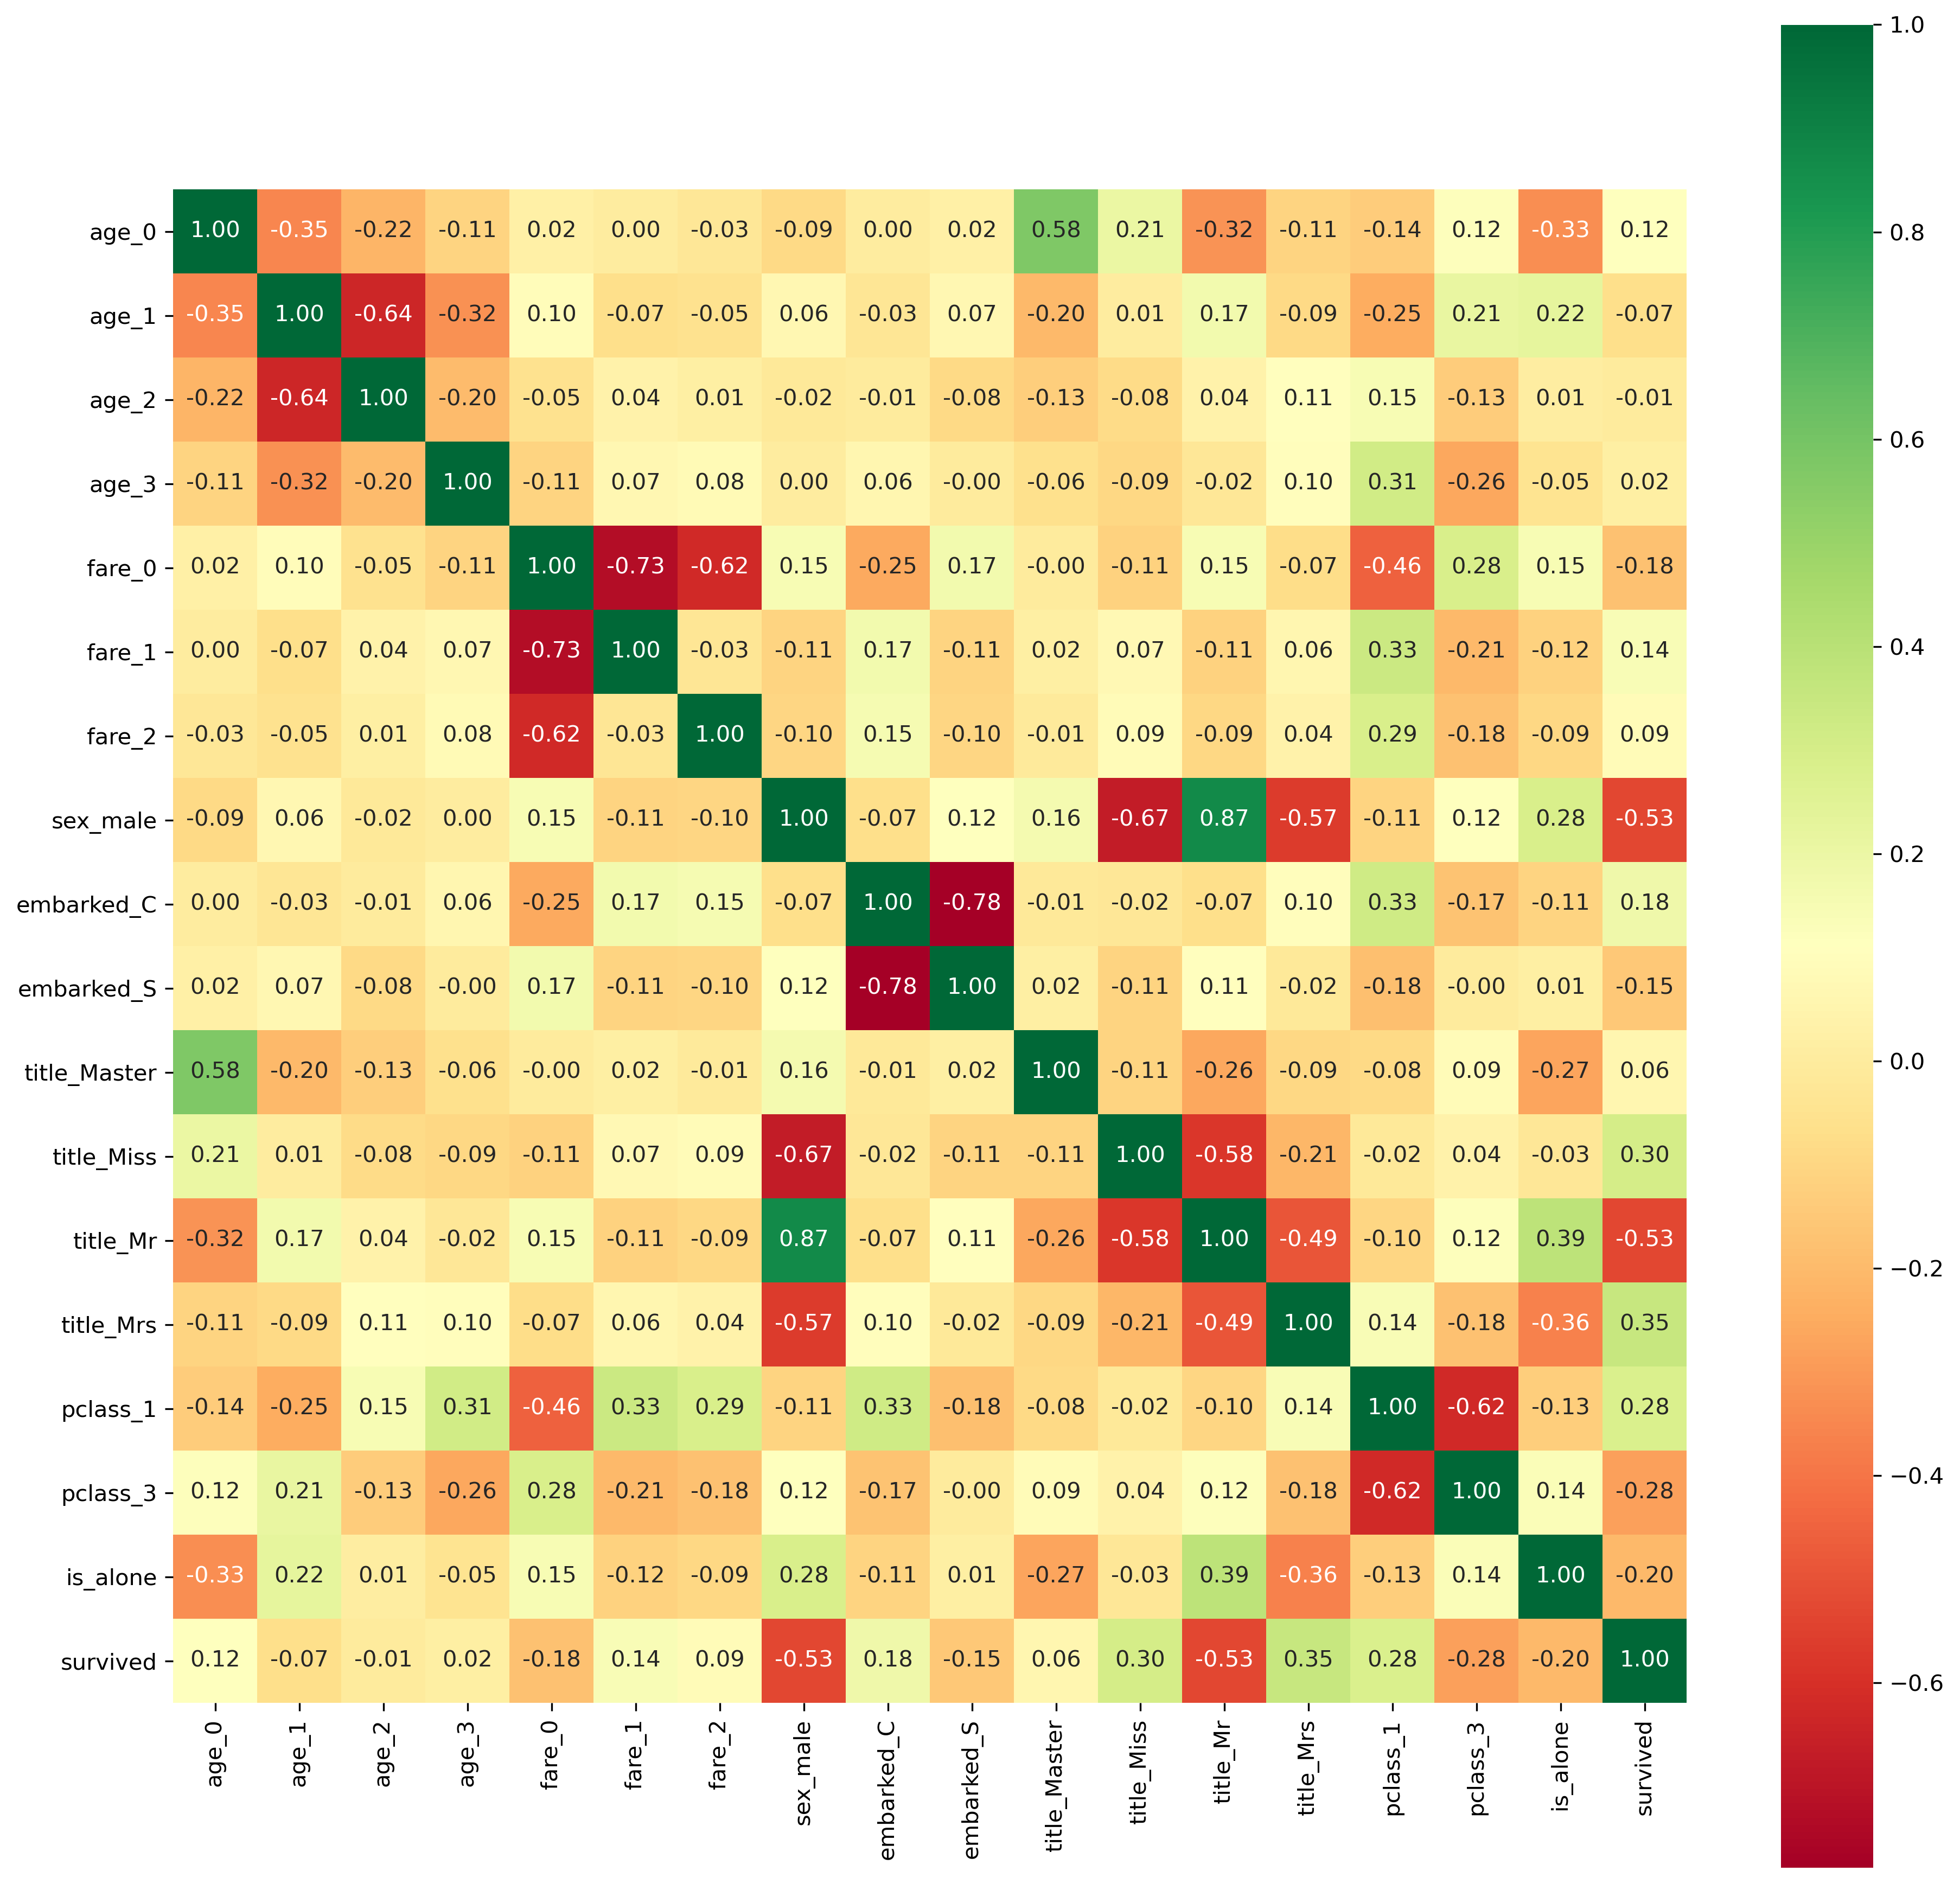

In [54]:
sns.heatmap(df_preprocessed.corr(), annot=True, cmap='RdYlGn', square=True, fmt='.2f');

We notice that some features are not correlated enough with our target 'survived' to be kept, like 'age_1', 'age_2', 'age_'3 or 'fare_1' and 'fare_2' or even 'title_Master'.

We can also see that the best features are 'sex_male' and 'title_Mr' with a strong negative correlation: being a male and/or having 'Mr' in his name is a strong indication that death is coming.
The 'age' and 'fare' correlations with our target also inform us that is not very pertinent to know a passenger's exact age or exact fair, but only if he is very young or not, or if he paid very little or not.

We also notice colinearity: for example, 'sex_male' is strongly correlated with our title-related features, which makes sense as a gender implies the titles a passenger has access to. This a a bad thing as these features share information, making them partially redundant.

Another way to select our features is to use RFECV, Recursive Feature Eliminatino with Cross-Validation. 

Without going into too much details, RFECV will allow us to test most combinations of features and see the configuration that performs best with a given model, here it's a RandomForestClassifier.

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(X_train, y_train, target):
    all_cols = X_train.columns
    rf = RandomForestClassifier(criterion="gini", max_depth=5, random_state=1)
    selector = RFECV(rf, cv=10, step=1)
    selector.fit(X_train, y_train)
    
    best_columns = list(X_train.columns[selector.support_])
    removed_cols = [col for col in all_cols if col not in best_columns]
    if len(removed_cols) > 0:
        print("removed:")
        print(removed_cols)
    else:
        print("kept everything")
    return best_columns


features = select_features(X_train, y_train, target="survived")
features

removed:
['age_1', 'age_2', 'age_3', 'fare_1', 'fare_2']


['age_0',
 'fare_0',
 'sex_male',
 'embarked_C',
 'embarked_S',
 'title_Master',
 'title_Miss',
 'title_Mr',
 'title_Mrs',
 'pclass_1',
 'pclass_3',
 'is_alone']

For the 'age' and 'fare' features, RFECV decided to only keep 'age_0' and 'fare_0', which is what we would choose to do using only the correlations.

More interestingly, it decided to keep 'title_Master' even though it has almost no correlation with our target. We will drop this feature as, even though it might have made this exact model better, intuitively it should not happen on average. We expect better results on most models by dropping it.

In [56]:
features = [f for f in features if f not in ["title_Master"]]

In [57]:
features

['age_0',
 'fare_0',
 'sex_male',
 'embarked_C',
 'embarked_S',
 'title_Miss',
 'title_Mr',
 'title_Mrs',
 'pclass_1',
 'pclass_3',
 'is_alone']

In [58]:
X_train, X_test = X_train[features], X_test[features]

<a id="hyperparameterOptimization"><a/>

## Hyperparameter Optimization
Let's now train models.

In this section, we will train many different models following 9 different algorithms. For each one, we will use GridSearch to try many combinations of hyperparameters to find the best one.

In [59]:
from sklearn.model_selection import GridSearchCV

def get_best_model(X_train, y_train, models): 
    for model in models:
        print(model['name'])
        print('-' * len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(X_train, y_train)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [60]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

models = [
    {
        "name": "K Nearest Neighbors",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": [2, 3, 4, 5, 7, 10, 15, 20],
                "weights": ["uniform", "distance"],
                "p": [1, 2]
            }
    },
    {
        "name": "Linear Support Vector Machines Classifier",
        "estimator": svm.LinearSVC(),
        "hyperparameters":
            {
                "loss": ["hinge", "squared_hinge"]
            }
    },
    {
        "name": "Linear Discriminant Analysis",
        "estimator": LinearDiscriminantAnalysis(),
        "hyperparameters":
            {
                "solver": ["svd", "lsqr", "eigen"]
            }
    },
    {
        "name": "Logistic Regressor",
        "estimator": LogisticRegression(),
        "hyperparameters":
            {
                "solver": ["lbfgs", "sag", "saga"],
                "max_iter": [100, 300, 500, 1000]
            }
    },
    {
        "name": "Decision Tree Classifier",
        "estimator": DecisionTreeClassifier(),
        "hyperparameters":
            {
                "criterion": ["gini", "entropy"],
                "splitter": ["best", "random"],
                "max_depth": [5, 7, 10, 15, 25, None]
            }
    },
    {
        "name": "Random Forest Classifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
            {
                "criterion": ["gini", "entropy"],
                "max_depth": [5, 7, 10, 15, 25, None]
            }
    },
    {
        "name": "Gradient Boosting Classifier",
        "estimator": GradientBoostingClassifier(),
        "hyperparameters":
            {
                "loss": ["deviance", "exponential"],
                "learning_rate": [.1, .2, .5],
                "max_depth": [5, 7, 10, 15, 25, None]
            }
    },
    {
        "name": "Ada Boost Classifier",
        "estimator": AdaBoostClassifier(),
        "hyperparameters":
            {
            }
    }
]

In [61]:
# Prevents warning messages from appearing
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [62]:
best_models = get_best_model(X_train, y_train, models)

K Nearest Neighbors
-------------------
Best Score: 0.806996336996337
Best Parameters: {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

Linear Support Vector Machines Classifier
-----------------------------------------
Best Score: 0.7859706959706959
Best Parameters: {'loss': 'squared_hinge'}

Linear Discriminant Analysis
----------------------------
Best Score: 0.7878937728937727
Best Parameters: {'solver': 'svd'}

Logistic Regressor
------------------
Best Score: 0.7859798534798536
Best Parameters: {'max_iter': 100, 'solver': 'lbfgs'}

Decision Tree Classifier
------------------------
Best Score: 0.8117673992673993
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'}

Random Forest Classifier
------------------------
Best Score: 0.8165384615384615
Best Parameters: {'criterion': 'entropy', 'max_depth': 5}

Gradient Boosting Classifier
----------------------------
Best Score: 0.8127197802197802
Best Parameters: {'learning_rate': 0.2, 'loss': 'deviance', 'max

## Decision Tree Classifier Visualization
To better understand how the features are exploited by our models, we can visualize our best iteration of the Decision Tree Classifier.

### Reading the Plot
* Each node is a decision point
* value = [n, n2] means that on that node, n people died and n2 survived
* class value is the class that would be predicted for passengers getting to that node (depending on if n>n2 or n<n2)
* colors translate the proportion of passengers in that node who survived or died: blue means they all survived, orange means they all died, white means they split evenly

#### Beginning of the Tree

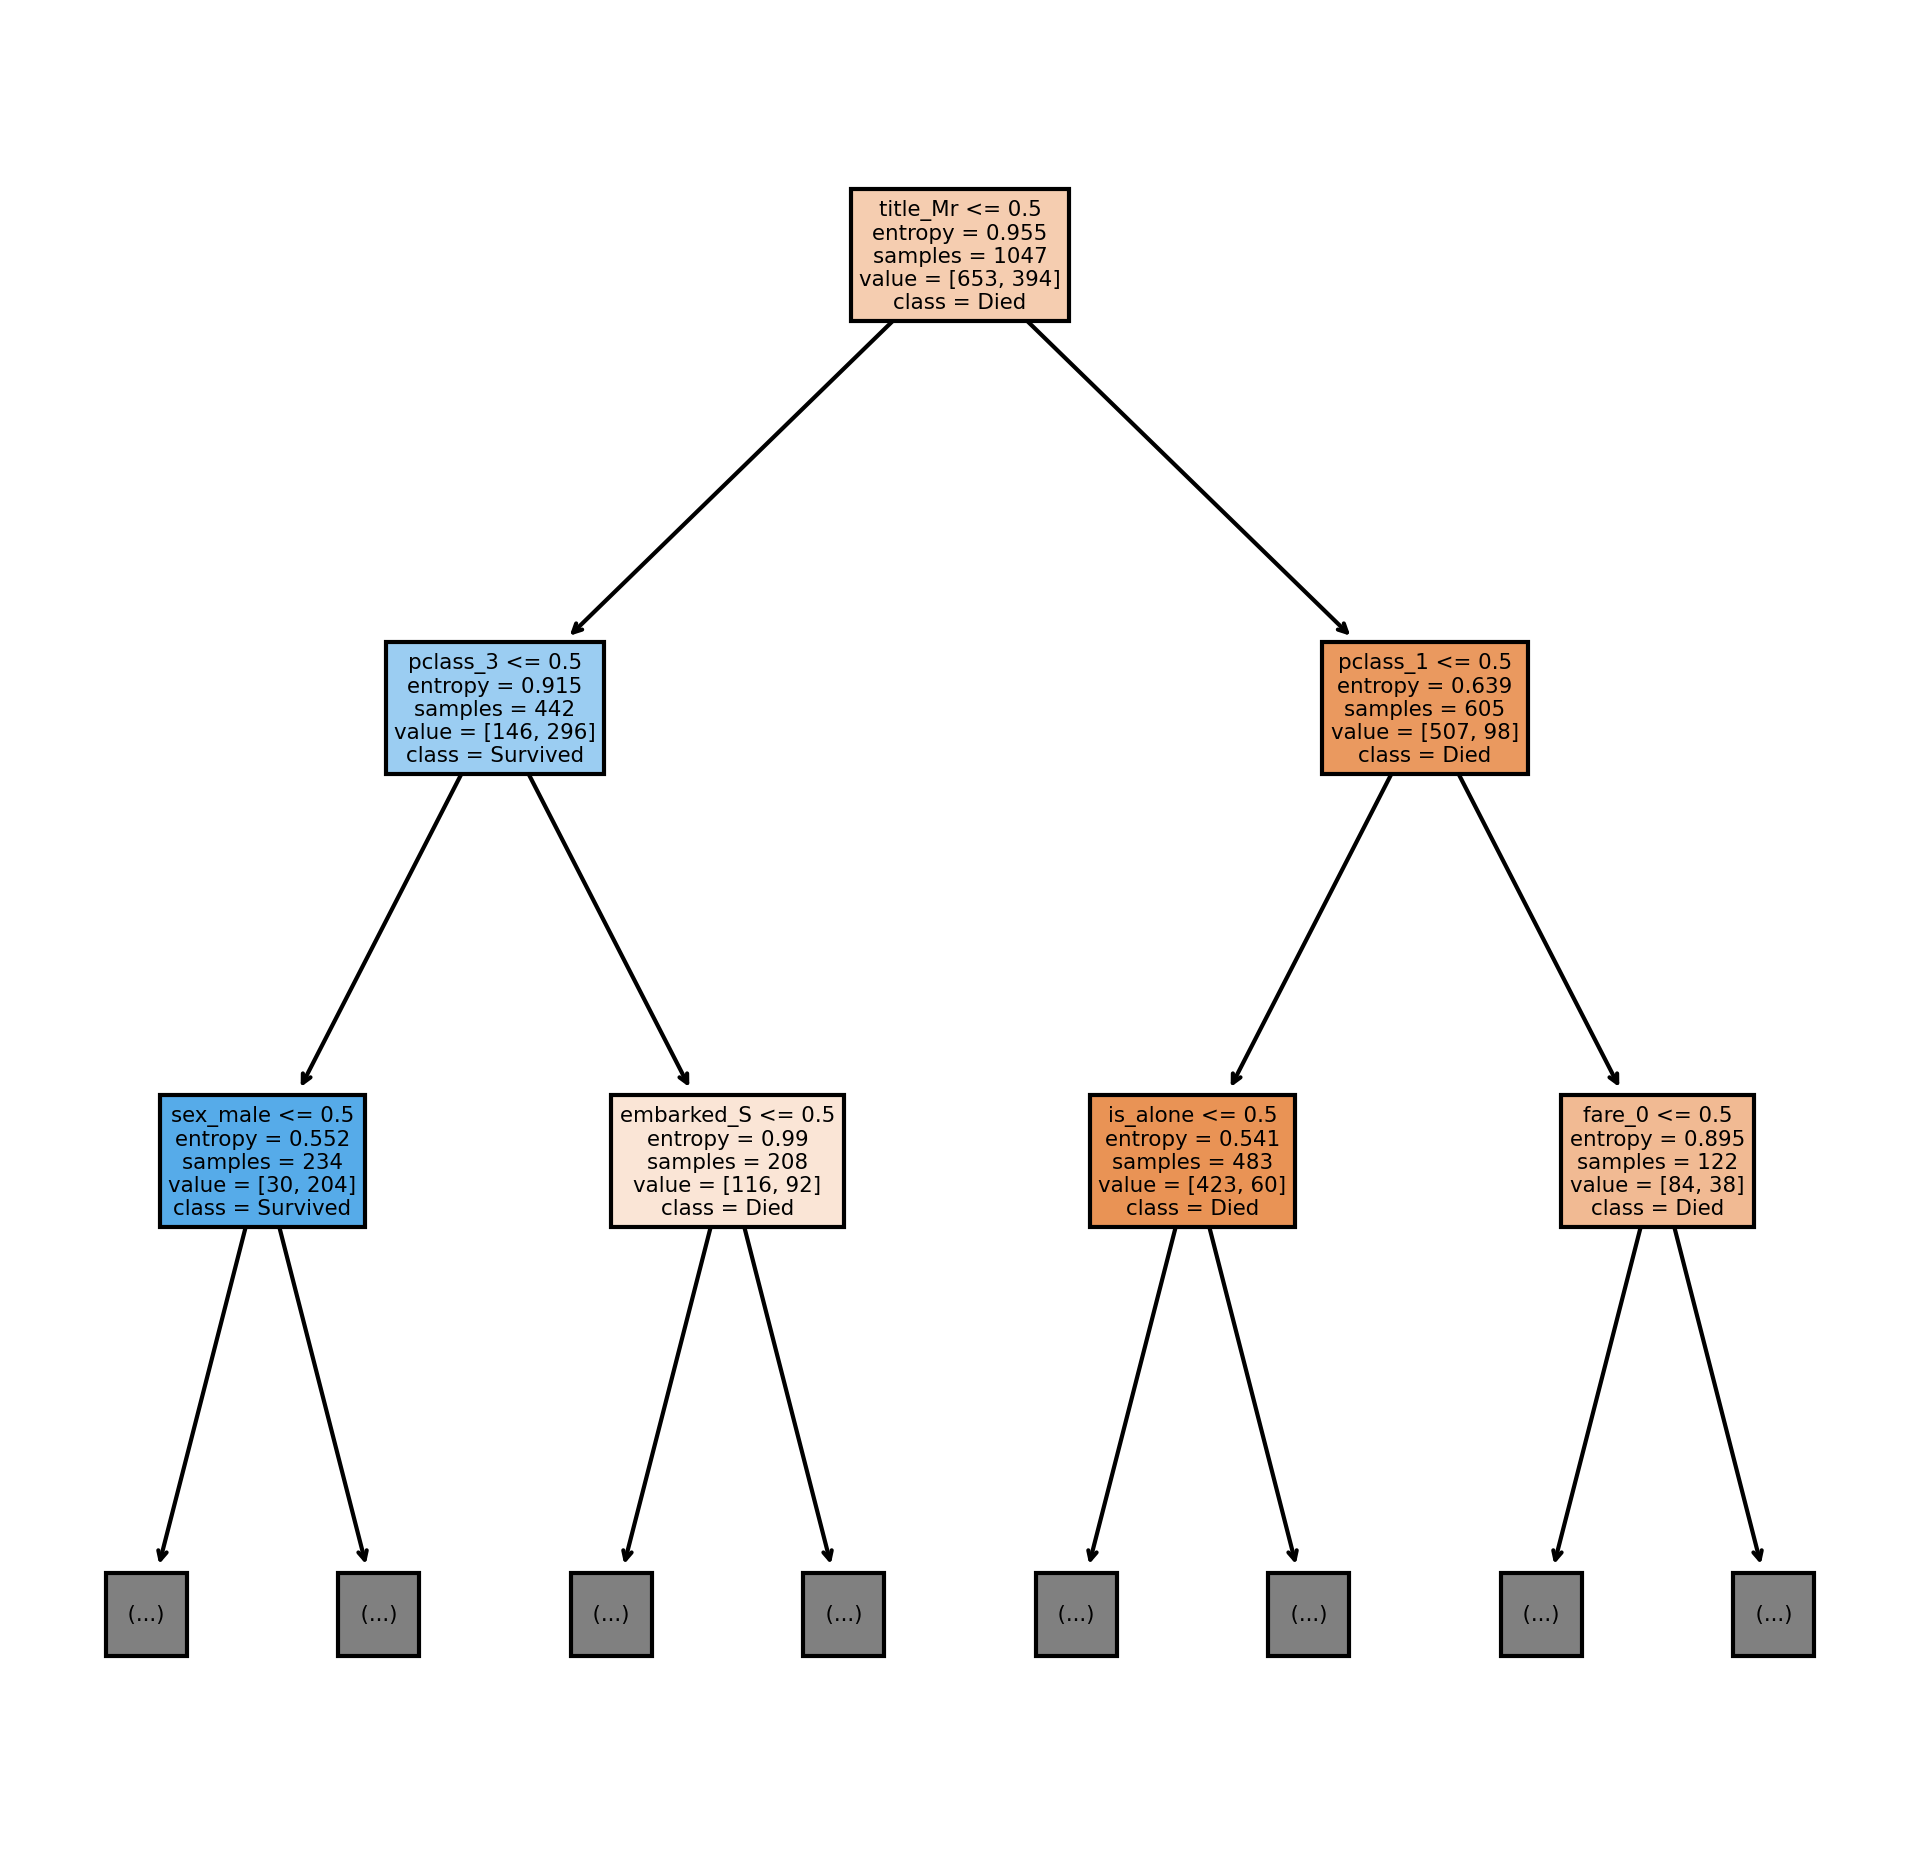

In [63]:
from sklearn import tree

mpl.rcParams['figure.figsize'] = 8, 8
best_tree = [model for model in best_models if model["name"] == "Decision Tree Classifier"][0]["best_model"]
tree.plot_tree(best_tree, max_depth=2, feature_names=X_train.columns, filled=True, class_names=["Died", "Survived"]);

#plt.savefig('decision_tree_small.png', bbox_inches="tight")

#### Full Tree

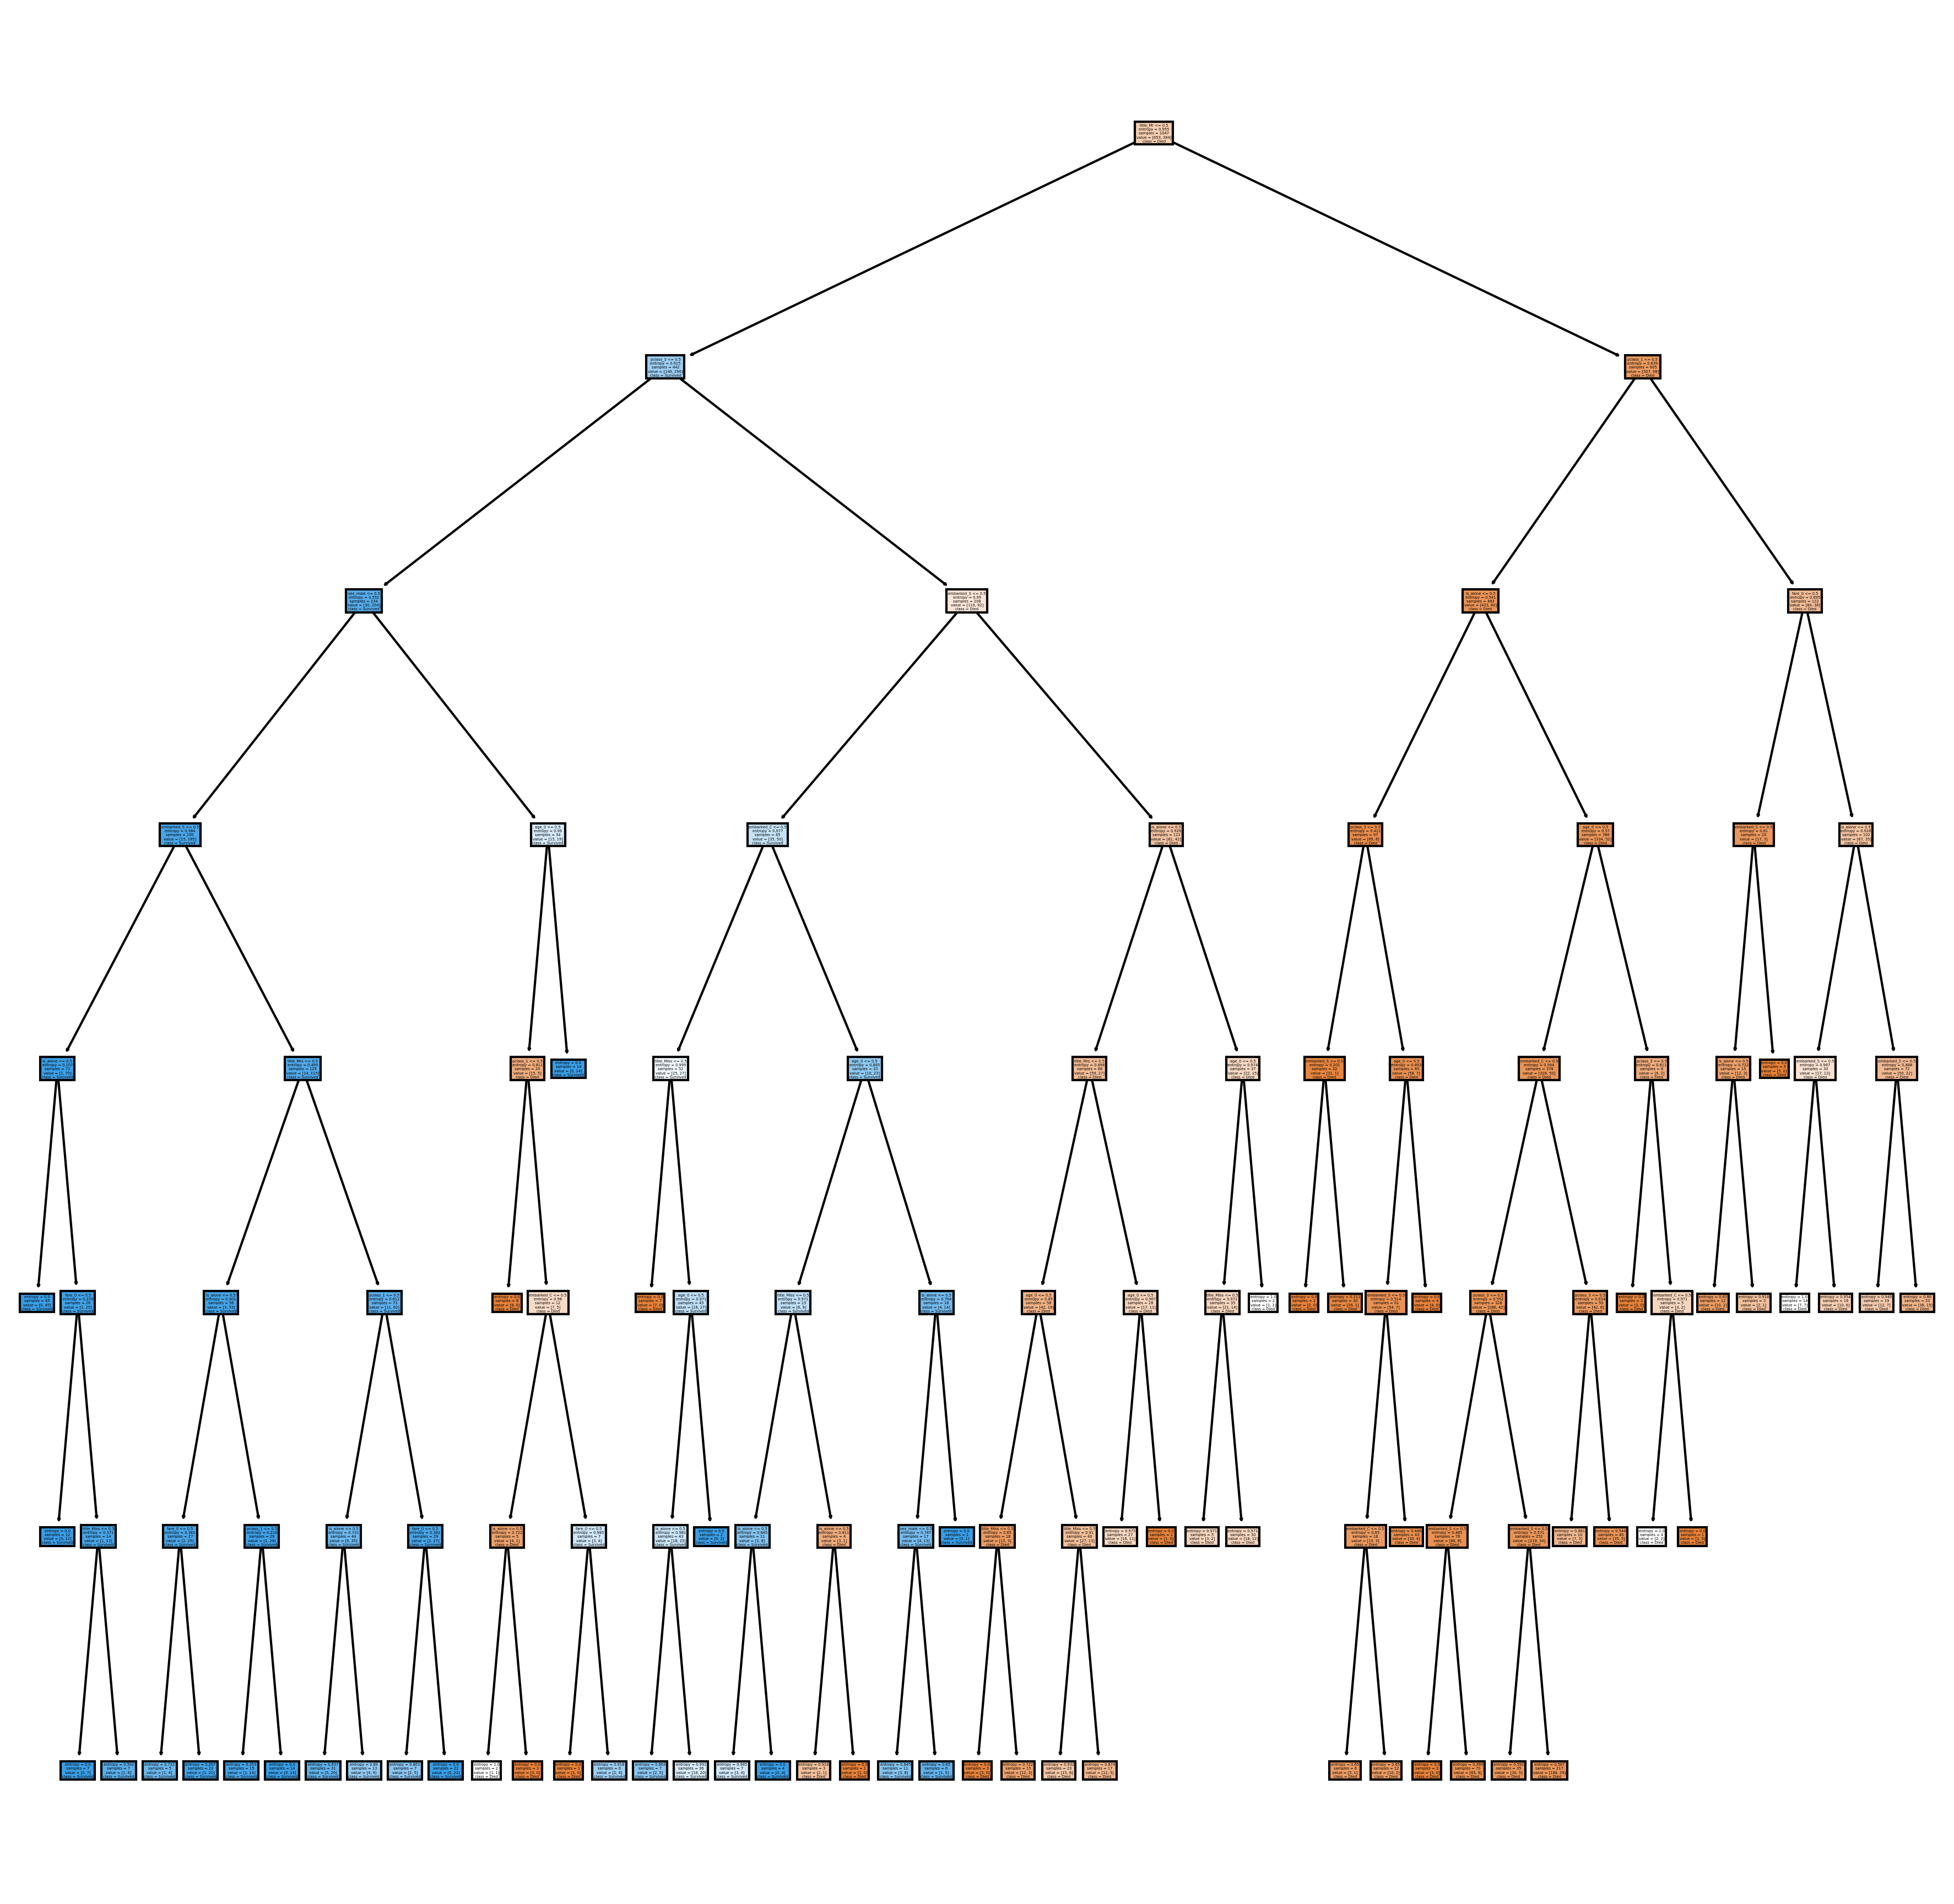

In [64]:
mpl.rcParams['figure.figsize'] = 15, 15
mpl.rcParams['figure.dpi'] = 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)        # tells matplotlib to save plots at 300 DPI

tree.plot_tree(best_tree, feature_names=X_train.columns, filled=True, class_names=["Died", "Survived"]);
#plt.savefig('decision_tree.png', bbox_inches="tight");

(you can right-click and "open image in new tab" to read this plot better)

A passenger having the title "Mr" will always be considered dead by this decision tree classifier. Giving him more information will influence its confidence, but the predicted class will always be "Died". With no more information, this verdict was right 507/605=84% of the time on the training set.

Similarly, telling this decision tree about a class 1 or class 2 female passenger will result in a "Survived" predicted class (by looking at the left branch of the decision tree, not having the 'Mr' title is implied by being a female). This verdict was right 185/200=92.5% on the training set.

### Voting model

The 'Voting' model will combine the prediction power of 5 different models (best iteration of each). For each prediction, it will predict the mode or most common value among the predictions made by these 5 models.

In [65]:
vote_names = [
    "K Nearest Neighbors", 
    "Linear Support Vector Machines Classifier", 
    "Linear Discriminant Analysis",
    "Logistic Regressor",
    "Decision Tree Classifier"
]
models_to_vote = [(model["name"], model["best_model"]) for model in best_models if model["name"] in vote_names]
models_to_vote

[('K Nearest Neighbors',
  KNeighborsClassifier(n_neighbors=20, p=1, weights='distance')),
 ('Linear Support Vector Machines Classifier', LinearSVC()),
 ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
 ('Logistic Regressor', LogisticRegression()),
 ('Decision Tree Classifier',
  DecisionTreeClassifier(criterion='entropy', max_depth=7))]

In [66]:
from sklearn.ensemble import VotingClassifier

vote_model = [
    {
        "name": "Voting Classifier",
        "estimator": VotingClassifier(estimators=models_to_vote),
        "hyperparameters":
            {
                "voting": ["hard"],
                "n_jobs": [-1]
            }
    }
]

In [67]:
best_voting = get_best_model(X_train, y_train, vote_model)

Voting Classifier
-----------------
Best Score: 0.7907509157509157
Best Parameters: {'n_jobs': -1, 'voting': 'hard'}



<a id="modelSelection"><a/>

## Model Selection
Now that we found the 'best' version of each model, we need to evaluate and compare them to select one.

But which metrics should we focus on? It depends on the context. This project did not give us more context other than trying to predict if a passenger survives or dies.

We will imagine a context in which we would do that: we are trying identify what tends to cause a passenger to die in order to educate similar passengers on similar journeys.

In this context:
* false negatives from the point of view of dying (you will likely die but the model misses it) (recall) are way more of a problem than false positives (you will probably survive but the model says you will likely die): we are better of being over-cautious. We will therefore value the recall from the point of view of dying highly.
* the time it takes to predict a passenger's fate is not a concern as long as it's reasonable

The score the model gets on the test set is always a good metric, and, to a lesser extent than for the recall, we will also consider the precision by using the f1-score as having a better precision does still matter. By using the f1-score and the recall, we consider the recall 1.5 times, but that is acceptable as this is in this context the most important metric.
We will also make sure that our selected model is stable, generalizes well, which we will define here as having less than 5% score difference between the train and test scores.

We will therefore compute an equity for each model as 0 if the model is unstable or 'test_score' * 'recall' * 'f1_score'.
We will sort the DataFrame by descending equity.

In [68]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time

def get_metrics_of_model(model, X_test, y_test, X_train, y_train):
    start_time = time.time()
    predictions = model.predict(X_test)
    delay = time.time() - start_time
    predict_time_per_row_ms = delay / len(X_test) * 1000000
    
    train_score, test_score = model.score(X_train, y_train), model.score(X_test, y_test)
    is_stable = train_score-test_score < .05
    
    labels = ["Died", "Survived"]
    classification_report_dict = classification_report(y_test, predictions, output_dict=True, target_names=labels)
    d = classification_report_dict["Died"]
    precision, recall, f1_score = d["precision"], d["recall"], d["f1-score"]
    
    c_m = confusion_matrix(y_test, predictions)
    equity = 0 if not is_stable else test_score * recall * f1_score
    return train_score, test_score, is_stable, precision, recall, f1_score, c_m, predict_time_per_row_ms, equity

def get_all_metrics_df(models, model_names, X_test, y_test, X_train, y_train):
    all_metrics = [get_metrics_of_model(m, X_test, y_test, X_train, y_train) for m in models]
    metric_names = ["train_score", "test_score", "is_stable", "precision", "recall", "f1_score", "confusion_matrix", "predict_time_µs", "equity"]
    metrics = [[metrics_tuple[i] for metrics_tuple in all_metrics] for i in range(len(metric_names))]
    
    data = [model_names] + metrics
    columns = ["model"] + metric_names
    metrics_dict = {metric_names[i]: metrics[i] for i in range(len(metric_names))}
    df_dict = {"model": model_names}
    df_dict.update(metrics_dict)
    df = pd.DataFrame(df_dict)
    return df.sort_values("equity", ascending=False)

In [69]:
all_ms = [m["best_model"] for m in best_models + best_voting]
all_names = [m["name"] for m in best_models + best_voting]
get_all_metrics_df(all_ms, all_names, X_test, y_test, X_train, y_train)

,model,train_score,test_score,is_stable,precision,recall,f1_score,confusion_matrix,predict_time_µs,equity
5,Random Forest Classifier,0.821394,0.812977,True,0.771574,0.974359,0.861190,"[[152, 4], [45, 61]]",55.426860,0.682176
6,Gradient Boosting Classifier,0.825215,0.816794,True,0.784211,0.955128,0.861272,"[[149, 7], [41, 65]]",11.495961,0.671915
4,Decision Tree Classifier,0.824260,0.805344,True,0.766497,0.967949,0.855524,"[[151, 5], [46, 60]]",7.676714,0.666908
0,K Nearest Neighbors,0.821394,0.797710,True,0.753695,0.980769,0.852368,"[[153, 3], [50, 56]]",31.692381,0.666866
1,Linear Support Vector Machines Classifier,0.791786,0.832061,True,0.837349,0.891026,0.863354,"[[139, 17], [27, 79]]",7.642134,0.640080
2,Linear Discriminant Analysis,0.791786,0.832061,True,0.837349,0.891026,0.863354,"[[139, 17], [27, 79]]",6.587451,0.640080
3,Logistic Regressor,0.798472,0.816794,True,0.810345,0.903846,0.854545,"[[141, 15], [33, 73]]",7.598455,0.630873
8,Voting Classifier,0.798472,0.816794,True,0.810345,0.903846,0.854545,"[[141, 15], [33, 73]]",64.943583,0.630873
7,Ada Boost Classifier,0.787011,0.816794,True,0.841772,0.852564,0.847134,"[[133, 23], [25, 81]]",41.989880,0.589918


We note that:
* Even though Linear Support Vector Machines and Linear Discriminant Analysis have a significantly better test score, the most popular metric, in this context we would exclude them as they have a significantly worse recall.
* The first 4 models have a very similar equity between 0.666866 and 0.666908, so we will pick one among them
* The first 2 models have the exact same equity, test_score, recall and f1_score. In fact, they would be identical if it was not for the train_score and the predict_time_ms. It makes sense as a Random Forest Classifier is made out of Decision Tree Classifiers. Between these two models, the winner is the Decision Tree Classifier as it offers the exact same prediction performance but takes 7.5 times less time to do so: in a second with my hardware, this model could predict the fate of about 130 000 passengers. Another reason to select this algorithm is that it is one of the clearer, easier one to explain and analyze.

The model we select in our context is therefore the Decision Tree Classifier.

In a more general context, we would select the Linear Discriminant Analysis model.